In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import Package

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.applications.convnext import ConvNeXtSmall
from tensorflow.keras.applications.convnext import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import itertools

import warnings
warnings.filterwarnings("ignore")

2024-07-24 12:34:35.252963: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 12:34:35.253067: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 12:34:35.388856: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Handling Dataset

In [2]:
image_size = 224
batch_size = 16
dir_data = "/kaggle/input/brain-tumor-mri-dataset"

In [3]:
train_paths = []
train_labels = []

test_paths = []
test_labels = []

filepath = os.listdir(dir_data)
for path in filepath:
    if path == 'Training':
        list_labels = os.listdir(os.path.join(dir_data, path))
        for label in list_labels:
            label_path = os.path.join(dir_data, path, label)
            files_list = os.listdir(label_path)
            for file in files_list:
                files = os.path.join(label_path, file)
                train_paths.append(files)
                train_labels.append(label)  # Use label instead of path
    else:
        list_labels = os.listdir(os.path.join(dir_data, path))
        for label in list_labels:
            label_path = os.path.join(dir_data, path, label)
            files_list = os.listdir(label_path)
            for file in files_list:
                files = os.path.join(label_path, file)
                test_paths.append(files)
                test_labels.append(label)  # Use label instead of path


In [4]:
train_series = pd.Series(train_paths, name='file path')
label_train_series = pd.Series(train_labels, name='label')
train_df = pd.concat([train_series, label_train_series], axis=1)
train_df.head()

file path      label
0  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
1  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
2  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
3  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
4  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary

In [5]:
test_series = pd.Series(test_paths, name='file path')
label_test_series = pd.Series(test_labels, name='label')
test_df = pd.concat([test_series, label_test_series], axis=1)
test_df.head()

file path      label
0  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
1  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
2  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
3  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
4  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary

In [9]:
valid_df, df_test = train_test_split(test_df, test_size = 0.5, shuffle=True, random_state=42)

In [10]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               horizontal_flip=True,
                               brightness_range=(1.1,1.3))
test_gen = ImageDataGenerator()
train_generator = train_gen.flow_from_dataframe(train_df,
                                 x_col='file path',
                                 y_col='label',
                                 target_size = (image_size,image_size),
                                 class_mode='categorical',
                                 color_mode='rgb',
                                 shuffle=True,
                                 batch_size=batch_size)
test_generator = test_gen.flow_from_dataframe(df_test,
                                 x_col='file path',
                                 y_col='label',
                                 target_size = (image_size,image_size),
                                 class_mode='categorical',
                                 color_mode='rgb',
                                 shuffle=False,
                                 batch_size=batch_size)
valid_generator = test_gen.flow_from_dataframe(valid_df,
                                 x_col='file path',
                                 y_col='label',
                                 target_size = (image_size,image_size),
                                 class_mode='categorical',
                                 color_mode='rgb',
                                 shuffle=True,
                                 batch_size=batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


## Modelling

In [8]:
def augmented_images(generator, num_batches):
    total_images = 0
    for i in range(num_batches):
        images, labels = next(generator)
        total_images += len(images)
        fig, axes = plt.subplots(1, len(images), figsize=(20, 20))
        for img, ax in zip(images, axes):
            ax.imshow(img.astype(np.uint8))
            ax.axis('off')
        plt.show()
    return total_images

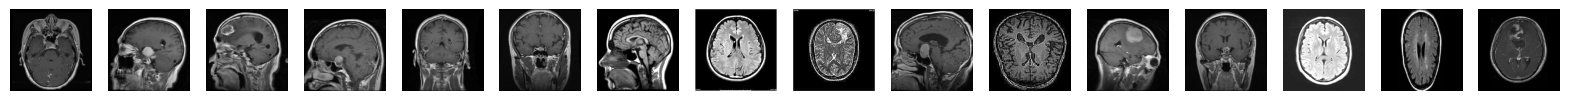

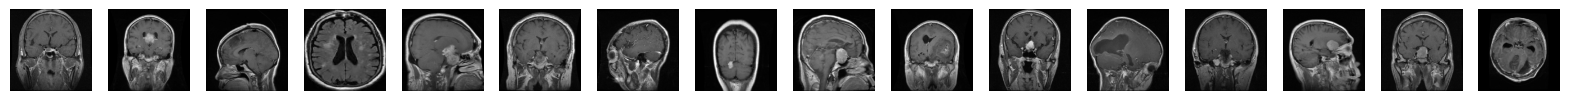

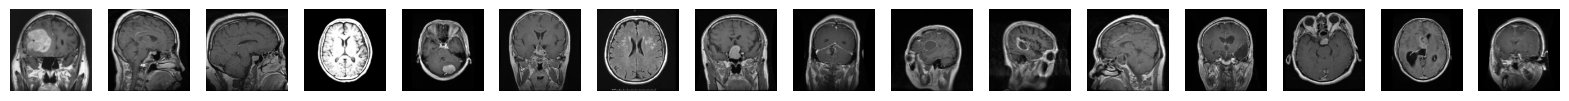

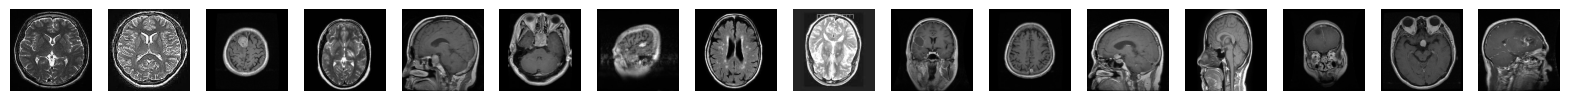

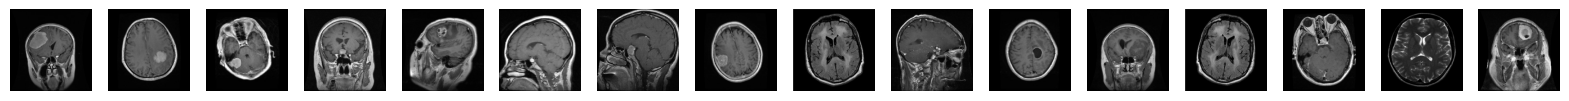

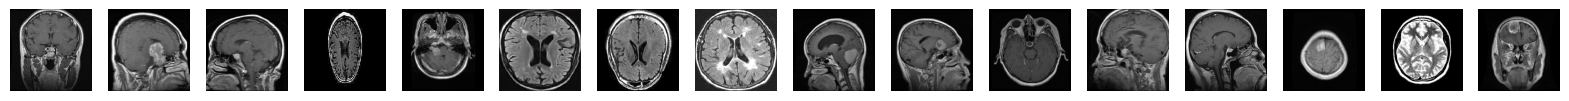

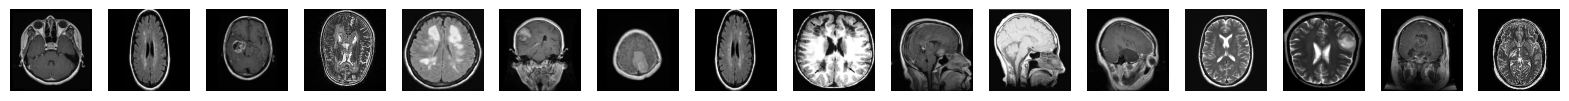

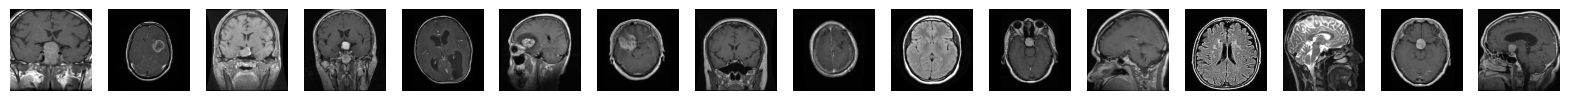

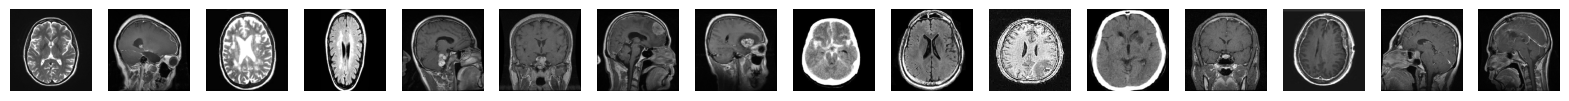

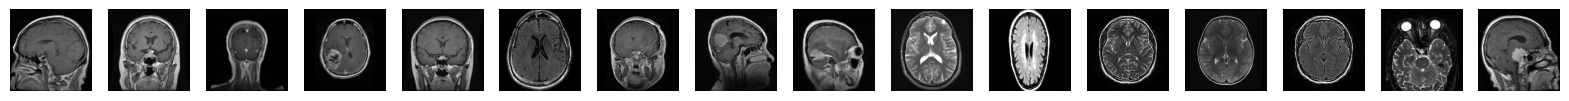

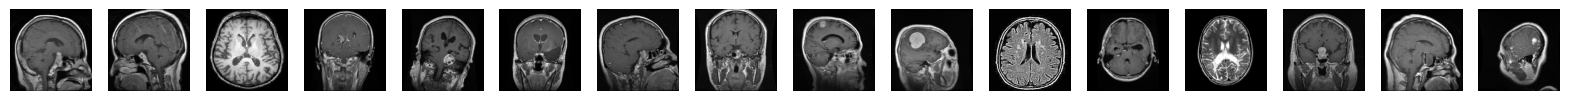

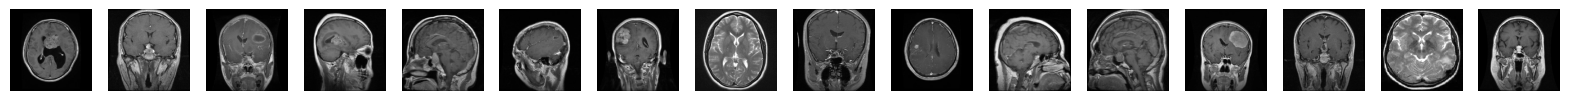

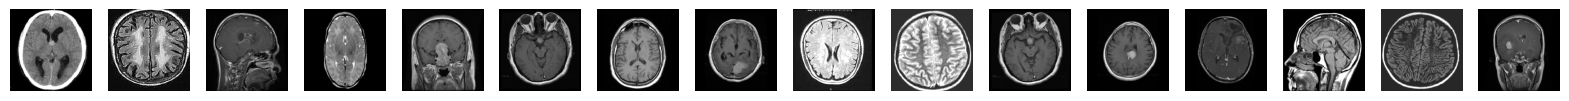

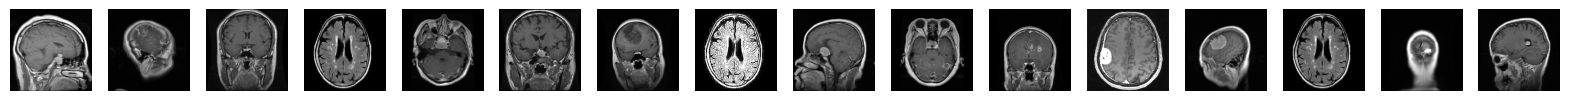

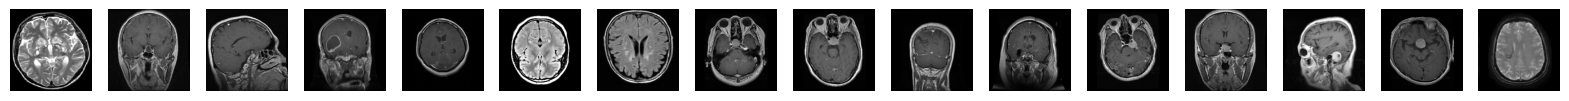

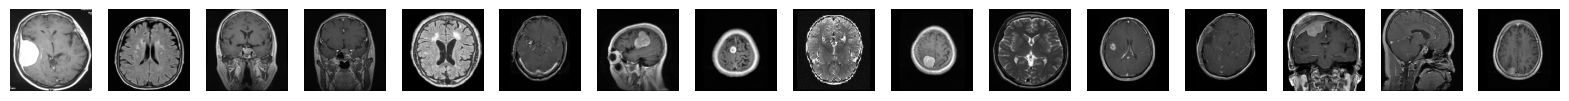

In [12]:
train_images = augmented_images(train_generator, batch_size)

In [13]:
print(f"Total gambar yang di-augmentasi dalam {batch_size} batch: {train_images}")

Total gambar yang di-augmentasi dalam 16 batch: 256


In [8]:
convnextsmall = ConvNeXtSmall(include_top=False,
                             weights="imagenet",
                             input_shape=(image_size,image_size,3),
                             pooling='max')

for layer in convnextsmall.layers[:-10]:
    layer.trainable = False

198551472/198551472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
def model_convnextsmall(optimizer, learning_rate, dropout, momentum=0.9):
    model = Sequential([
    convnextsmall,
    layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    layers.Dense(512, kernel_regularizer = regularizers.l1_l2(l1=0.0005, l2=0.001),
                activation='relu'),
    layers.Dropout(dropout),
    layers.Dense(4, activation='softmax')
    ])
    
    if optimizer == tf.keras.optimizers.SGD:
        optimizer_instance = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    else:
        optimizer_instance =optimizer(learning_rate=learning_rate)

    model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [12]:
def history_model(model, train_data, epoch, verbose, valid_data, shuffle):
    history = model.fit(train_data, epochs=epoch, 
                        verbose=verbose, validation_data=valid_data,
                       shuffle=shuffle)
    return history

In [13]:
import seaborn as sns
def plot_history(history):
    sns.set(style="whitegrid")

    plt.figure(figsize=(14, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    sns.lineplot(x=range(1, len(history.history['accuracy']) + 1), y=history.history['accuracy'], label='Training Accuracy')
    sns.lineplot(x=range(1, len(history.history['val_accuracy']) + 1), y=history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss values plot
    plt.subplot(1, 2, 2)
    sns.lineplot(x=range(1, len(history.history['loss']) + 1), y=history.history['loss'], label='Training Loss')
    sns.lineplot(x=range(1, len(history.history['val_loss']) + 1), y=history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [14]:
def evaluate_model(model, train, valid, test, verbose):
    train_score = model.evaluate(train, verbose=verbose)
    validation_score = model.evaluate(valid, verbose=verbose)
    test_score = model.evaluate(test, verbose=verbose)

In [15]:
def predict_model(model, test):
    preds = model.predict(test)
    y_pred = np.argmax(preds, axis=1)
    g_dict = test_generator.class_indices
    classes = list(g_dict.keys())
    cm = confusion_matrix(test.classes, y_pred)
    return y_pred, classes, cm

In [16]:
def plot_cm(cm, classes):
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, 
                yticklabels=classes, cbar=True, square=True)
    plt.title('Confusion Matrix')
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [17]:
def report_model(test, predict_test, classes):
    report = classification_report(test.classes, predict_test, target_names=classes)
    return print(report)

## Optimizer Adam

### Konfigurasi model 
- Learning rate = 0.001
- Dropout = 0.25

In [21]:
model_adam_1 = model_convnextsmall(Adam, 0.001, 0.25)

In [22]:
history_adam_1 = history_model(model_adam_1, train_generator, 30, 1, valid_generator, False)

Epoch 1/30
  1/357 ━━━━━━━━━━━━━━━━━━━━ 3:03:46 31s/step - accuracy: 0.2500 - loss: 8.9910

I0000 00:00:1721613300.435037     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721613300.487224     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721613300.487651     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721613300.488010     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721613300.488954     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721613300.489295     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721613300.489646     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721613300.489972     114 graph_launch.cc:671] Fallback to op-by-op mode because m

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7966 - loss: 6.4147

W0000 00:00:1721613352.140582     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721613352.140989     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721613352.141414     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721613352.142343     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721613352.142754     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721613352.143105     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721613352.143487     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721613352.143843     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 92s 170ms/step - accuracy: 0.7968 - loss: 6.4101 - val_accuracy: 0.9573 - val_loss: 2.0789
Epoch 2/30


W0000 00:00:1721613361.035843     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721613361.036290     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721613361.036776     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.9583 - loss: 1.4553 - val_accuracy: 0.9588 - val_loss: 0.6480
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.9723 - loss: 0.5089 - val_accuracy: 0.9603 - val_loss: 0.4922
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.9734 - loss: 0.4232 - val_accuracy: 0.9740 - val_loss: 0.4434
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.9862 - loss: 0.3146 - val_accuracy: 0.9847 - val_loss: 0.3217
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.9889 - loss: 0.2641 - val_accuracy: 0.9664 - val_loss: 0.4019
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.9810 - loss: 0.3233 - val_accuracy: 0.9817 - val_loss: 0.2542
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.9885 - loss: 0.2403 - val_accuracy: 0.9802 - val_loss: 0.3292
Epoch 9/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.9908 - loss: 0.2075 - val_accurac

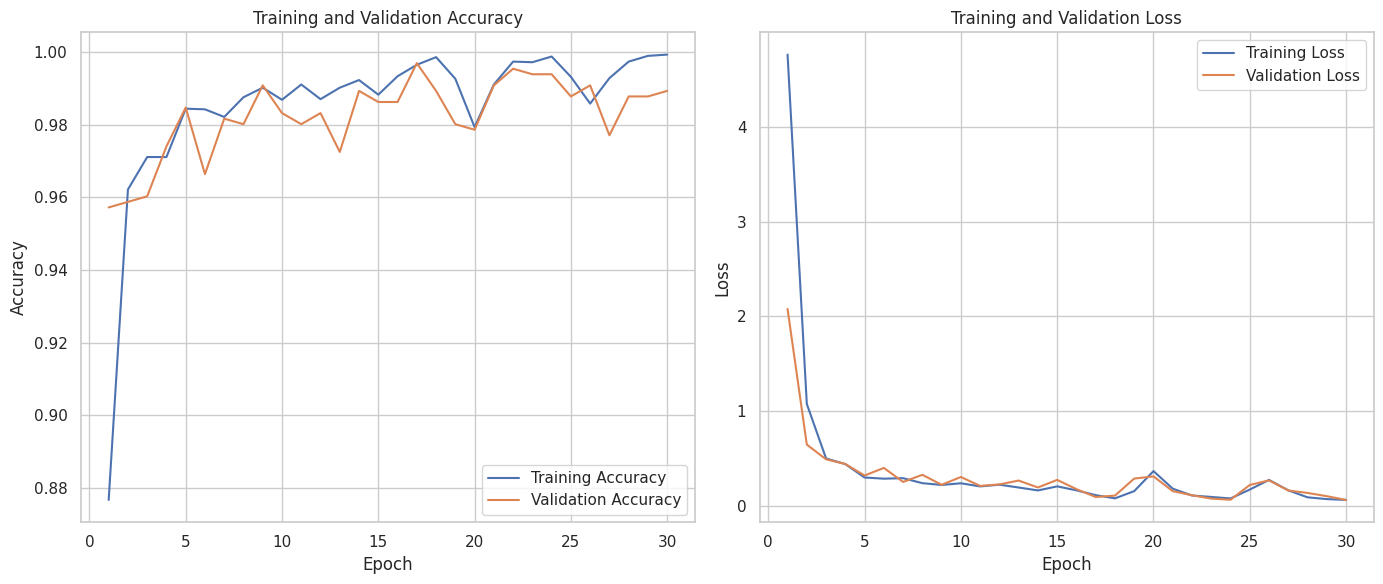

In [23]:
plot_history(history_adam_1)

In [24]:
evaluate_model(model_adam_1, train_generator, valid_generator,
               test_generator, 1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.9991 - loss: 0.0451
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9877 - loss: 0.0684
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.9884 - loss: 0.0868


In [25]:
y_pred_adam_1, classes, cm_adam_1 = predict_model(model_adam_1, test_generator)

 3/41 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step

W0000 00:00:1721614317.029203     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721614317.029531     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721614317.029934     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721614317.030840     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721614317.031179     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721614317.031535     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721614317.031871     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721614317.032219     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step


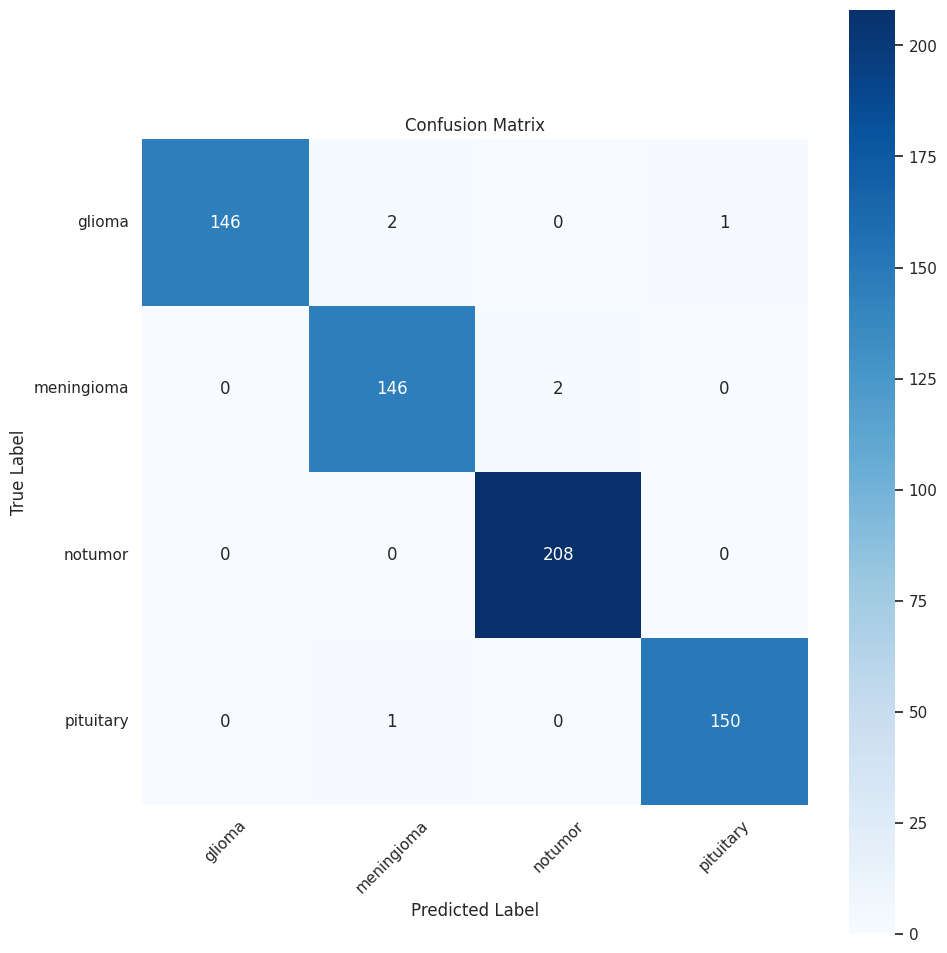

In [26]:
plot_cm(cm_adam_1, classes)

In [27]:
report_model(test_generator, y_pred_adam_1, classes)

              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       149
  meningioma       0.98      0.99      0.98       148
     notumor       0.99      1.00      1.00       208
   pituitary       0.99      0.99      0.99       151

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



In [28]:
model_adam_1.save('classification_brain_tumor_convnextsmall_adam.h5')

### Konfigurasi model 
- learning rate = 0.001
- dropout = 0.45

In [16]:
model_adam_2 = model_convnextsmall(Adam,0.001, 0.45)

In [17]:
history_adam_2 = history_model(model_adam_2, train_generator, 30, 1, valid_generator, False)

Epoch 1/30
  1/357 ━━━━━━━━━━━━━━━━━━━━ 3:04:47 31s/step - accuracy: 0.3125 - loss: 9.6340

I0000 00:00:1721615246.257527     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721615246.312012     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721615246.312316     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721615246.312760     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721615246.313706     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721615246.314055     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721615246.314377     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721615246.314722     103 graph_launch.cc:671] Fallback to op-by-op mode because m

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.7934 - loss: 6.6915

W0000 00:00:1721615312.018442     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721615312.018854     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721615312.019312     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721615312.020278     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721615312.020642     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721615312.021014     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721615312.021368     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721615312.021725     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 107s 213ms/step - accuracy: 0.7936 - loss: 6.6873 - val_accuracy: 0.9466 - val_loss: 2.6107
Epoch 2/30


W0000 00:00:1721615322.306820     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721615322.307212     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721615322.307686     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 32s 89ms/step - accuracy: 0.9601 - loss: 1.8789 - val_accuracy: 0.9618 - val_loss: 0.7686
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.9741 - loss: 0.6321 - val_accuracy: 0.9649 - val_loss: 0.6402
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.9789 - loss: 0.5019 - val_accuracy: 0.9802 - val_loss: 0.4954
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.9821 - loss: 0.4491 - val_accuracy: 0.9756 - val_loss: 0.5572
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.9776 - loss: 0.4775 - val_accuracy: 0.9725 - val_loss: 0.3699
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - accuracy: 0.9840 - loss: 0.3589 - val_accuracy: 0.9771 - val_loss: 0.3346
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - accuracy: 0.9922 - loss: 0.2633 - val_accuracy: 0.9786 - val_loss: 0.3873
Epoch 9/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - accuracy: 0.9901 - loss: 0.3095 - val_accurac

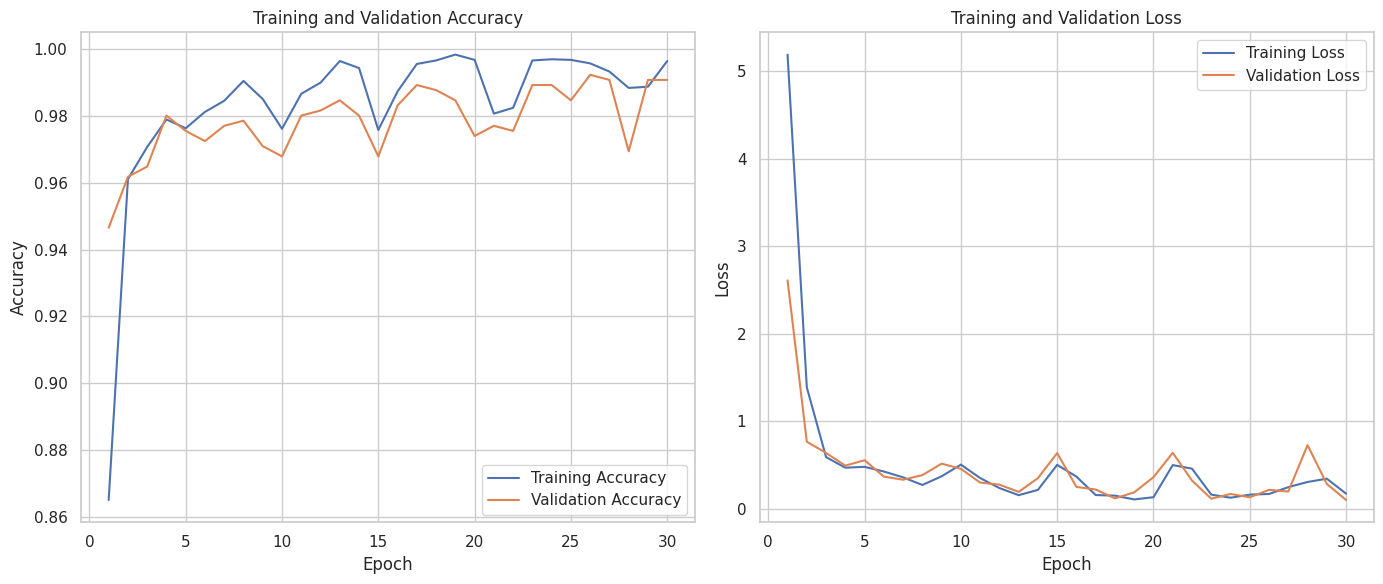

In [18]:
plot_history(history_adam_2)

In [19]:
evaluate_model(model_adam_2, train_generator, valid_generator,
               test_generator, 1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 28s 77ms/step - accuracy: 0.9997 - loss: 0.0776
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9930 - loss: 0.0987
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.9875 - loss: 0.1324


In [20]:
y_pred_adam_2, classes, cm_adam_2 = predict_model(model_adam_2, test_generator)

 4/41 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step

W0000 00:00:1721616361.498814     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721616361.499129     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721616361.499514     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721616361.500407     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721616361.500748     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721616361.501117     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721616361.501448     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721616361.501784     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step


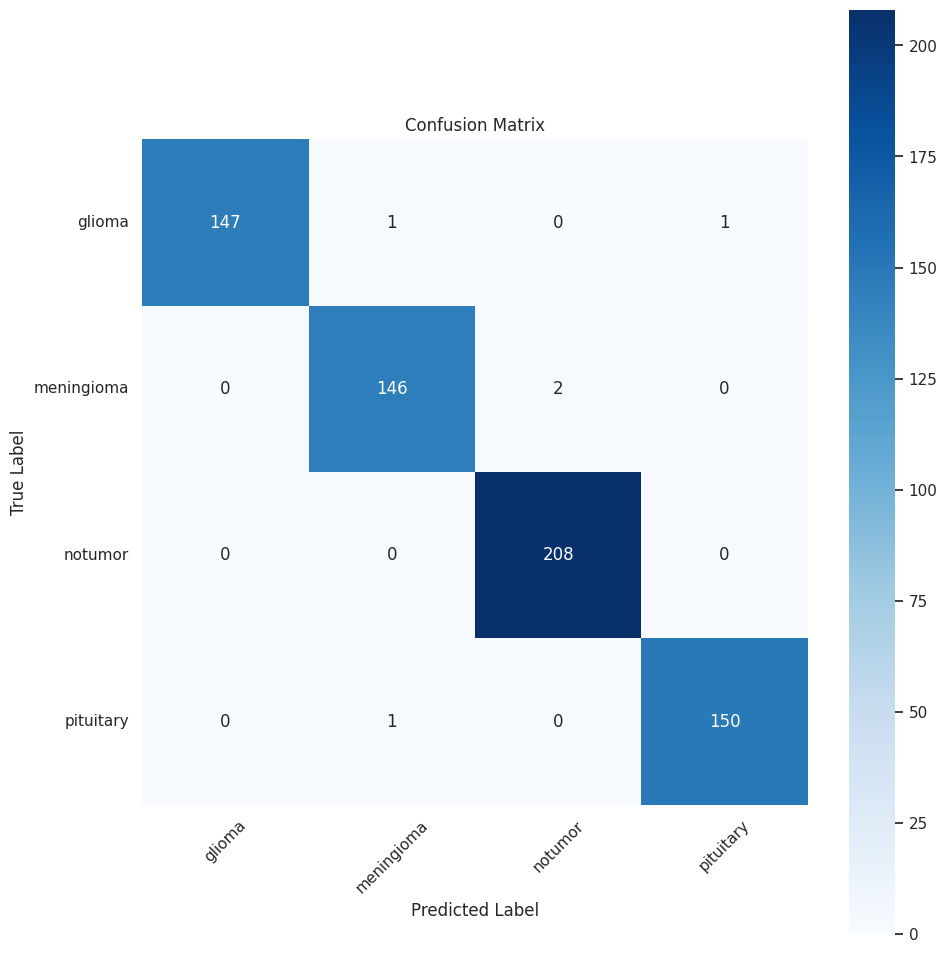

In [21]:
plot_cm(cm_adam_2, classes)

In [22]:
report_model(test_generator, y_pred_adam_2, classes)

              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       149
  meningioma       0.99      0.99      0.99       148
     notumor       0.99      1.00      1.00       208
   pituitary       0.99      0.99      0.99       151

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



In [23]:
model_adam_2.save('classification_brain_tumor_convnextsmall_adam_2.h5')

### Konfigurasi model
- learning rate = 0.0001
- dropout = 0.25

In [22]:
model_adam_3 = model_convnextsmall(Adam,0.0001, 0.25)

In [23]:
history_adam_3 = history_model(model_adam_3, train_generator, 30, 1, valid_generator, False)

Epoch 1/30
  1/357 ━━━━━━━━━━━━━━━━━━━━ 3:02:35 31s/step - accuracy: 0.2500 - loss: 9.3530

I0000 00:00:1721616871.065029     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721616871.118874     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721616871.119218     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721616871.119618     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721616871.120546     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721616871.120875     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721616871.121186     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721616871.121518     113 graph_launch.cc:671] Fallback to op-by-op mode because m

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6751 - loss: 8.0274

W0000 00:00:1721616926.462684     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721616926.462972     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721616926.463332     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721616926.464175     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721616926.464539     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721616926.464844     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721616926.465182     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721616926.465545     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 95s 180ms/step - accuracy: 0.6754 - loss: 8.0262 - val_accuracy: 0.8977 - val_loss: 6.9160
Epoch 2/30


W0000 00:00:1721616935.310540     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721616935.311031     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721616935.311553     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.9146 - loss: 6.6740 - val_accuracy: 0.9557 - val_loss: 5.9208
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - accuracy: 0.9660 - loss: 5.6655 - val_accuracy: 0.9695 - val_loss: 4.9493
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.9809 - loss: 4.6882 - val_accuracy: 0.9771 - val_loss: 3.9799
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.9921 - loss: 3.7154 - val_accuracy: 0.9802 - val_loss: 3.0501
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.9947 - loss: 2.8070 - val_accuracy: 0.9786 - val_loss: 2.2085
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.9975 - loss: 1.9926 - val_accuracy: 0.9832 - val_loss: 1.4896
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.9966 - loss: 1.3200 - val_accuracy: 0.9832 - val_loss: 0.9542
Epoch 9/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - accuracy: 0.9973 - loss: 0.8199 - val_accurac

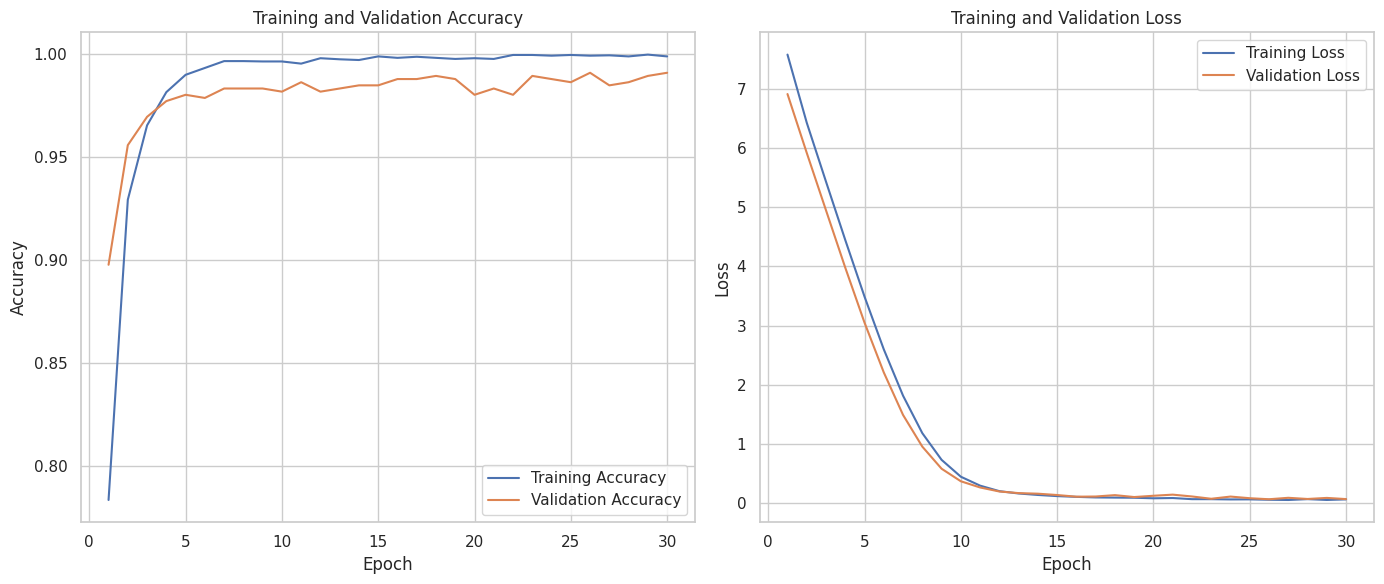

In [24]:
plot_history(history_adam_3)

In [25]:
evaluate_model(model_adam_3, train_generator, valid_generator,
               test_generator, 1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.9998 - loss: 0.0399
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9867 - loss: 0.0769
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9784 - loss: 0.1098


In [26]:
y_pred_adam_3, classes, cm_adam_3 = predict_model(model_adam_3, test_generator)

 3/41 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step

W0000 00:00:1721619045.911652     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721619045.912067     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721619045.912447     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721619045.913406     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721619045.913796     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721619045.914167     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721619045.914555     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721619045.914938     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step


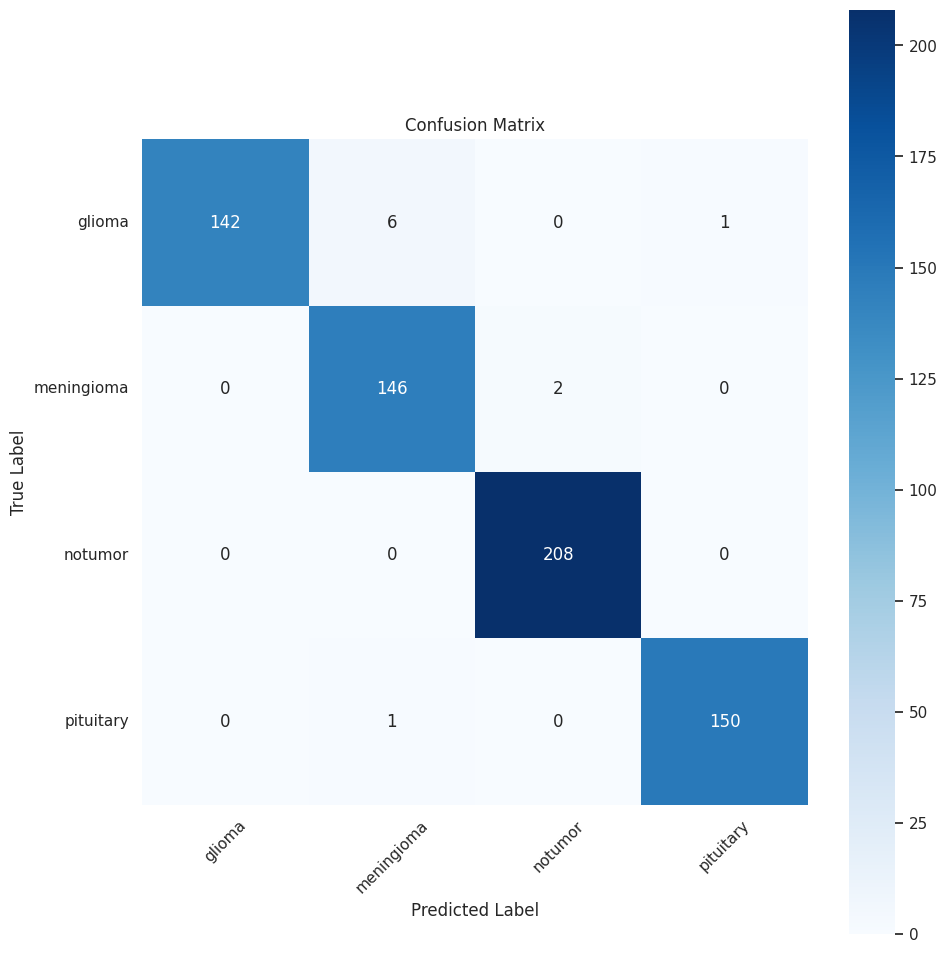

In [27]:
plot_cm(cm_adam_3, classes)

In [28]:
report_model(test_generator, y_pred_adam_3, classes)

              precision    recall  f1-score   support

      glioma       1.00      0.95      0.98       149
  meningioma       0.95      0.99      0.97       148
     notumor       0.99      1.00      1.00       208
   pituitary       0.99      0.99      0.99       151

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.99      0.98      0.98       656



In [29]:
model_adam_3.save('classification_brain_tumor_convnextsmall_adam_3.h5')

### Konfigurasi model 
- learning rate = 0.0001
- dropout = 0.45

In [19]:
model_adam_4 = model_convnextsmall(Adam, 0.0001, 0.45)

In [20]:
history_adam_4 = history_model(model_adam_4, train_generator, 30, 1, valid_generator, False)

Epoch 1/30
  1/357 ━━━━━━━━━━━━━━━━━━━━ 3:01:15 31s/step - accuracy: 0.2500 - loss: 9.1995

I0000 00:00:1721619684.547851     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721619684.602163     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721619684.602558     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721619684.602956     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721619684.603929     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721619684.604291     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721619684.604647     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721619684.605017     107 graph_launch.cc:671] Fallback to op-by-op mode because m

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6105 - loss: 8.2147

W0000 00:00:1721619737.809374     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721619737.809699     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721619737.810120     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721619737.811084     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721619737.811409     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721619737.811722     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721619737.812059     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721619737.812369     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 92s 174ms/step - accuracy: 0.6108 - loss: 8.2135 - val_accuracy: 0.8794 - val_loss: 7.1030
Epoch 2/30


W0000 00:00:1721619746.464575     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721619746.464942     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721619746.465360     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721619746.470973     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721619746.471331     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721619746.471740     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.8871 - loss: 6.9225 - val_accuracy: 0.9405 - val_loss: 6.2767
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.9409 - loss: 6.0932 - val_accuracy: 0.9649 - val_loss: 5.4633
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9682 - loss: 5.2748 - val_accuracy: 0.9725 - val_loss: 4.6648
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9780 - loss: 4.4634 - val_accuracy: 0.9802 - val_loss: 3.8574
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9879 - loss: 3.6598 - val_accuracy: 0.9802 - val_loss: 3.0876
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9919 - loss: 2.8927 - val_accuracy: 0.9847 - val_loss: 2.3651
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9958 - loss: 2.1838 - val_accuracy: 0.9832 - val_loss: 1.7231
Epoch 9/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9943 - loss: 1.5750 - val_accurac

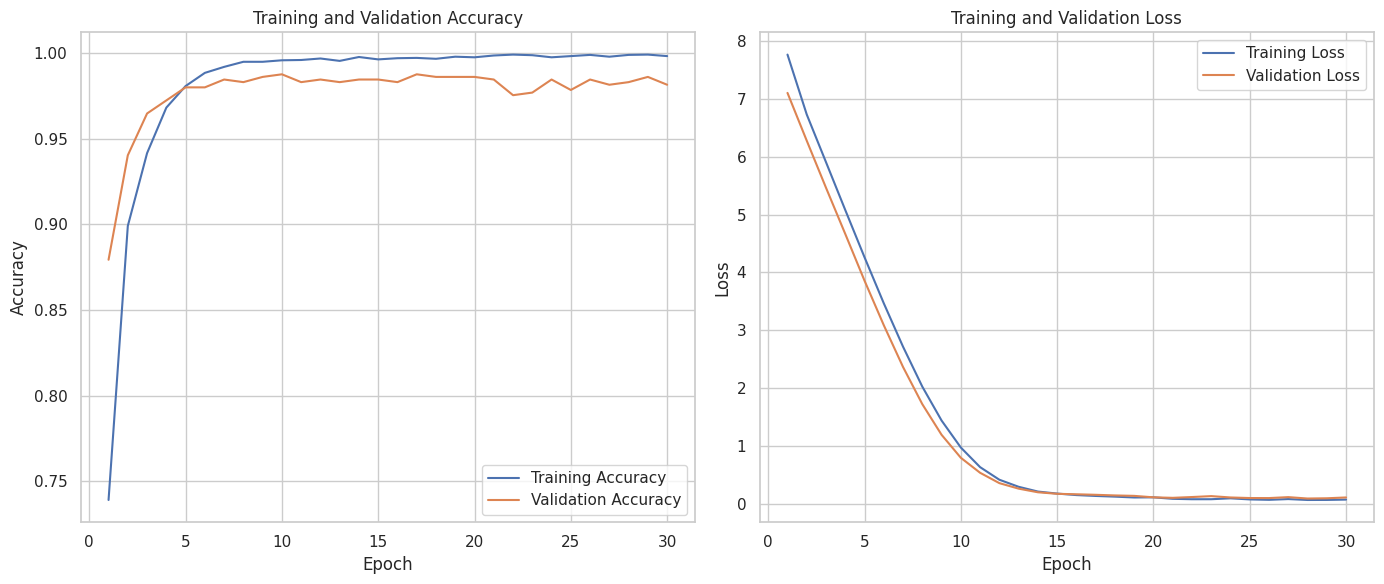

In [21]:
plot_history(history_adam_4)

In [22]:
evaluate_model(model_adam_4, train_generator, valid_generator,
               test_generator, 1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - accuracy: 0.9992 - loss: 0.0732
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9765 - loss: 0.1321
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.9810 - loss: 0.1169


In [24]:
y_pred_adam_4, classes, cm_adam_4 = predict_model(model_adam_4, test_generator)

 3/41 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step

W0000 00:00:1721620754.427838     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721620754.428207     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721620754.428587     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721620754.429542     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721620754.429920     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721620754.430273     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721620754.430623     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721620754.430998     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step


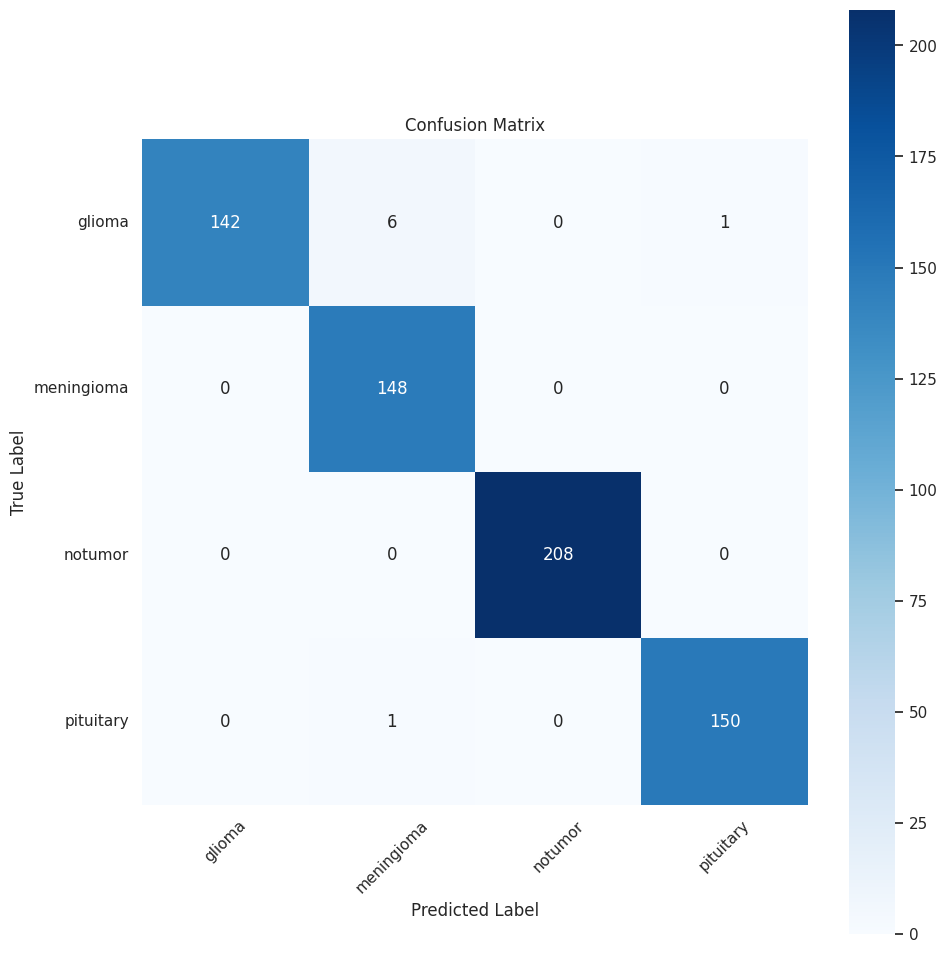

In [25]:
plot_cm(cm_adam_4, classes)

In [26]:
report_model(test_generator, y_pred_adam_4, classes)

              precision    recall  f1-score   support

      glioma       1.00      0.95      0.98       149
  meningioma       0.95      1.00      0.98       148
     notumor       1.00      1.00      1.00       208
   pituitary       0.99      0.99      0.99       151

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



In [27]:
model_adam_4.save('classification_brain_tumor_convnextsmall_adam_4.h5')

## Optimizer Adamax

### Konfigurasi model
- learning rate = 0.001
- Dropout = 0.25

In [19]:
model_adamax_1 = model_convnextsmall(Adamax,0.001, 0.25)

In [27]:
history_adamax_1 = history_model(model_adamax_1, train_generator, 30, 1, valid_generator, False)

Epoch 1/30
  1/357 ━━━━━━━━━━━━━━━━━━━━ 3:02:50 31s/step - accuracy: 0.3125 - loss: 9.4052

I0000 00:00:1721621118.443587     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721621118.500865     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721621118.501230     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721621118.501624     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721621118.501962     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721621118.502305     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721621118.502656     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721621118.502986     107 graph_launch.cc:671] Fallback to op-by-op mode because m

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8074 - loss: 7.2792

W0000 00:00:1721621172.598240     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721621172.598606     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721621172.598915     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721621172.599282     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721621172.599650     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721621172.599999     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721621172.600353     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721621172.600711     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 94s 177ms/step - accuracy: 0.8076 - loss: 7.2772 - val_accuracy: 0.9542 - val_loss: 5.2631
Epoch 2/30


W0000 00:00:1721621181.417568     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721621181.417928     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721621181.418342     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721621181.423767     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721621181.424053     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721621181.424547     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 33s 91ms/step - accuracy: 0.9716 - loss: 4.7220 - val_accuracy: 0.9756 - val_loss: 3.2987
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9871 - loss: 2.8548 - val_accuracy: 0.9786 - val_loss: 1.7602
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.9914 - loss: 1.4651 - val_accuracy: 0.9878 - val_loss: 0.8219
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9946 - loss: 0.6761 - val_accuracy: 0.9771 - val_loss: 0.4336
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9964 - loss: 0.3465 - val_accuracy: 0.9847 - val_loss: 0.2557
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.9961 - loss: 0.2247 - val_accuracy: 0.9756 - val_loss: 0.2639
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9963 - loss: 0.1729 - val_accuracy: 0.9832 - val_loss: 0.1784
Epoch 9/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9973 - loss: 0.1319 - val_accurac

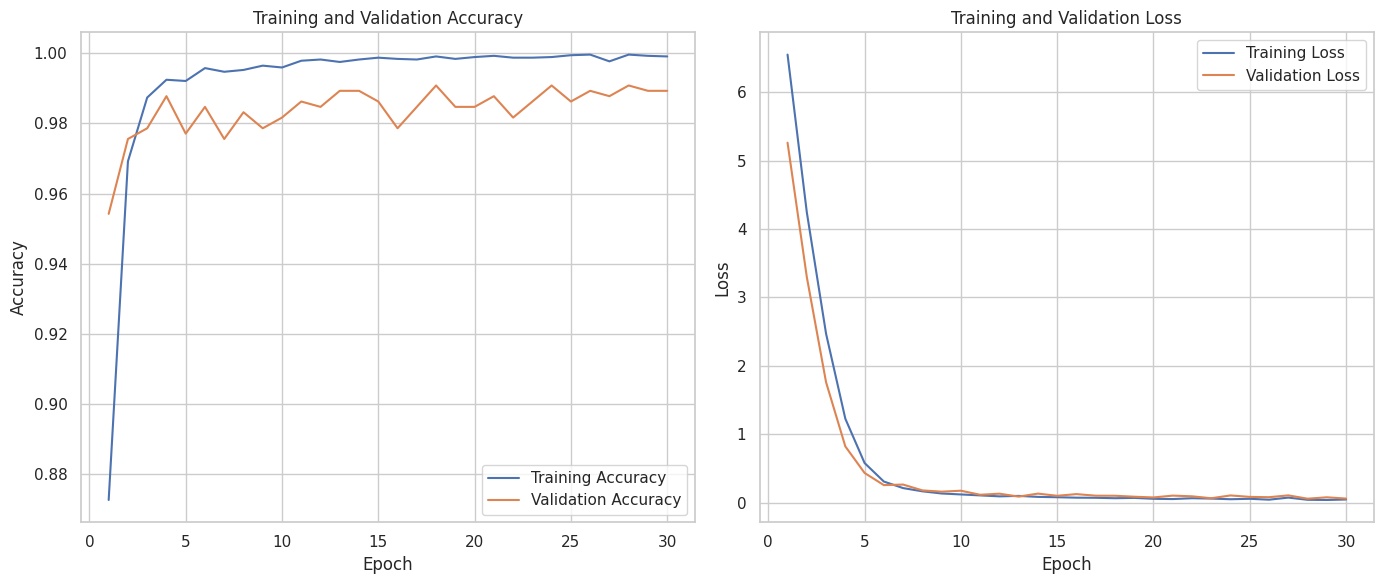

In [28]:
plot_history(history_adamax_1)

In [29]:
evaluate_model(model_adamax_1, train_generator, valid_generator,
               test_generator, 1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - accuracy: 0.9996 - loss: 0.0282
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9882 - loss: 0.0702
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.9829 - loss: 0.0826


In [30]:
y_pred_adamax_1, classes, cm_adamax_1 = predict_model(model_adamax_1, test_generator)

 3/41 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step

W0000 00:00:1721623166.516845     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721623166.517282     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721623166.517756     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721623166.518104     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721623166.518513     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721623166.518874     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721623166.519232     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721623166.519590     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step


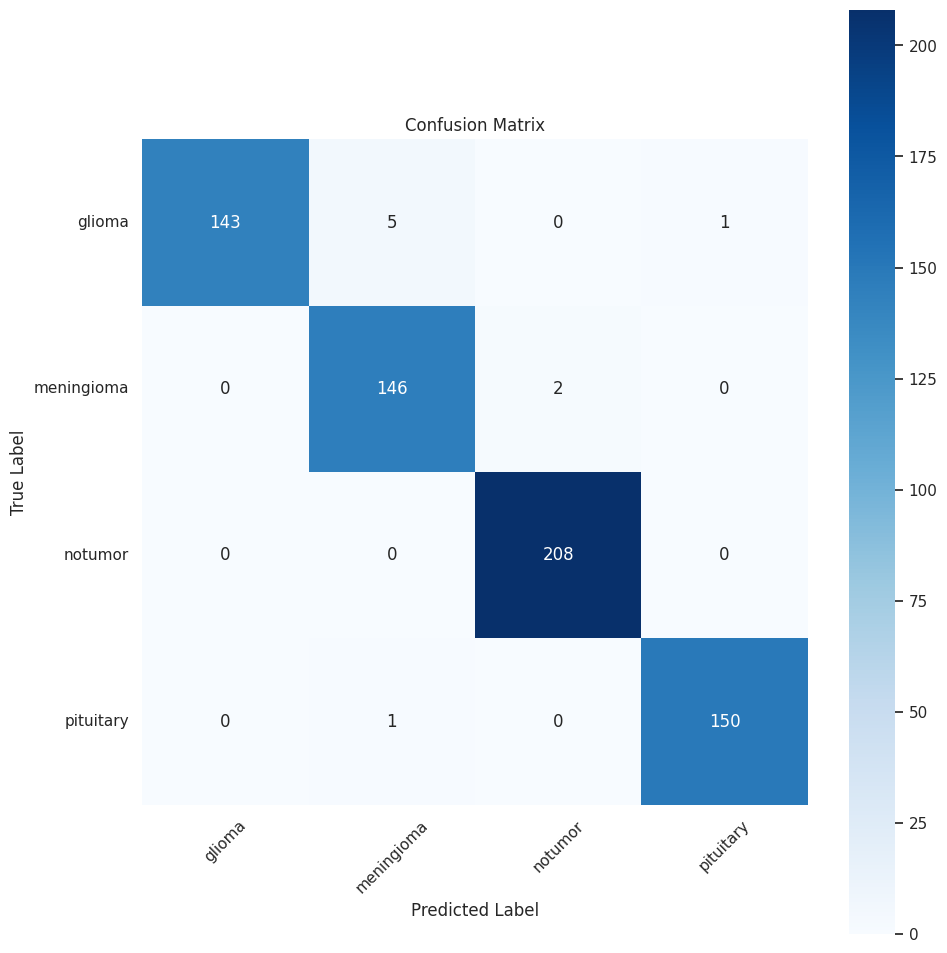

In [31]:
plot_cm(cm_adamax_1, classes)

In [32]:
report_model(test_generator, y_pred_adamax_1, classes)

              precision    recall  f1-score   support

      glioma       1.00      0.96      0.98       149
  meningioma       0.96      0.99      0.97       148
     notumor       0.99      1.00      1.00       208
   pituitary       0.99      0.99      0.99       151

    accuracy                           0.99       656
   macro avg       0.99      0.98      0.99       656
weighted avg       0.99      0.99      0.99       656



In [33]:
model_adamax_1.save('classification_brain_tumor_convnextsmall_adamax_1.h5')

### Konfigurasi model
- learning rate = 0.001
- dropout = 0.45

In [16]:
model_adamax_2 = model_convnextsmall(Adamax,0.001, 0.45)

In [17]:
history_adamax_2 = history_model(model_adamax_2, train_generator, 30, 1, valid_generator, False)

Epoch 1/30
  1/357 ━━━━━━━━━━━━━━━━━━━━ 3:09:16 32s/step - accuracy: 0.2500 - loss: 9.3368

I0000 00:00:1721627664.764637     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721627664.823133     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721627664.823601     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721627664.823990     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721627664.824397     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721627664.824776     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721627664.825169     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721627664.825543     114 graph_launch.cc:671] Fallback to op-by-op mode because m

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7711 - loss: 7.4968

W0000 00:00:1721627714.216250     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721627714.216620     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721627714.217047     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721627714.217456     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721627714.217828     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721627714.218203     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721627714.218568     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721627714.218917     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 90s 162ms/step - accuracy: 0.7713 - loss: 7.4950 - val_accuracy: 0.9435 - val_loss: 5.6926
Epoch 2/30


W0000 00:00:1721627722.469085     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721627722.469564     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721627722.470020     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721627722.477643     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721627722.478104     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721627722.478646     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9468 - loss: 5.2712 - val_accuracy: 0.9725 - val_loss: 4.0208
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.9806 - loss: 3.6360 - val_accuracy: 0.9802 - val_loss: 2.6057
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9885 - loss: 2.2813 - val_accuracy: 0.9832 - val_loss: 1.5009
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9910 - loss: 1.2838 - val_accuracy: 0.9878 - val_loss: 0.7944
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9958 - loss: 0.6703 - val_accuracy: 0.9847 - val_loss: 0.4486
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9964 - loss: 0.3763 - val_accuracy: 0.9863 - val_loss: 0.3011
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9966 - loss: 0.2430 - val_accuracy: 0.9878 - val_loss: 0.2193
Epoch 9/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.9964 - loss: 0.1864 - val_accurac

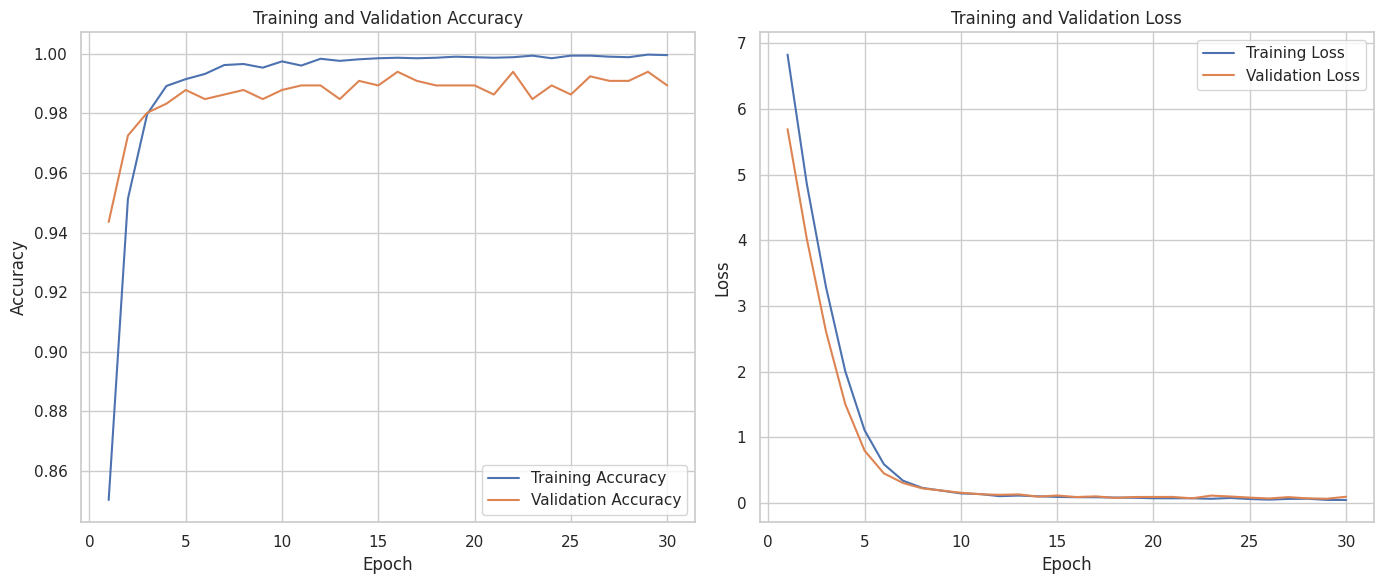

In [18]:
plot_history(history_adamax_2)

In [19]:
evaluate_model(model_adamax_2, train_generator, valid_generator,
               test_generator, 1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.9996 - loss: 0.0687
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9863 - loss: 0.0931
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9882 - loss: 0.1163


In [20]:
y_pred_adamax_2, classes, cm_adamax_2 = predict_model(model_adamax_2, test_generator)

 3/41 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step

W0000 00:00:1721628679.848213     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721628679.848615     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721628679.849035     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721628679.849378     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721628679.849736     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721628679.850117     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721628679.850461     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721628679.850810     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step


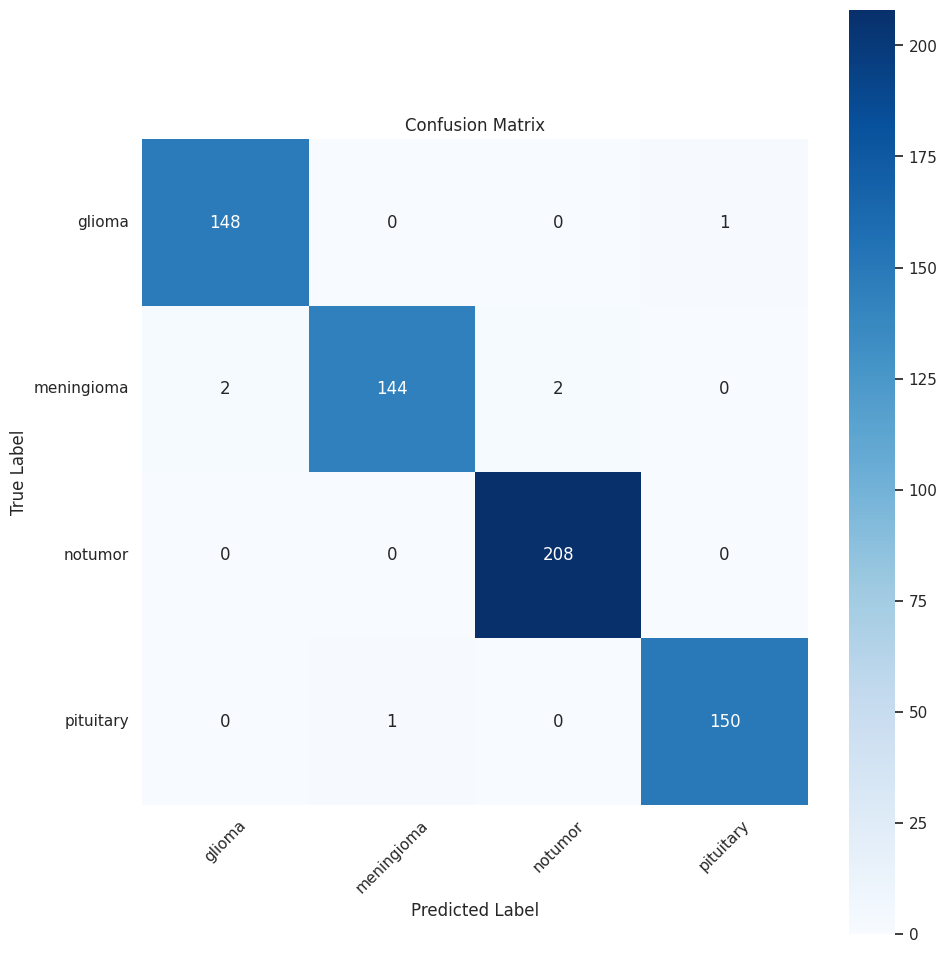

In [21]:
plot_cm(cm_adamax_2, classes)

In [22]:
report_model(test_generator, y_pred_adamax_2, classes)

              precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       149
  meningioma       0.99      0.97      0.98       148
     notumor       0.99      1.00      1.00       208
   pituitary       0.99      0.99      0.99       151

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



In [23]:
model_adamax_2.save('classification_brain_tumor_convnextsmall_adamax_2.h5')

### Konfigurasi model
- learning rate = 0.0001
- dropout = 0.25

In [17]:
model_adamax_3 = model_convnextsmall(Adamax,0.0001, 0.25)

In [18]:
history_adamax_3 = history_model(model_adamax_3, train_generator, 30, 1, valid_generator, False)

Epoch 1/30
  1/357 ━━━━━━━━━━━━━━━━━━━━ 2:57:52 30s/step - accuracy: 0.2500 - loss: 9.3410

I0000 00:00:1721822604.508059     102 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721822604.562531     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721822604.562894     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721822604.563305     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721822604.564319     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721822604.564718     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721822604.565077     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721822604.565448     102 graph_launch.cc:671] Fallback to op-by-op mode because m

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.5571 - loss: 8.3929

W0000 00:00:1721822682.919555     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721822682.919970     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721822682.920312     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721822682.921239     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721822682.921562     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721822682.921901     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721822682.922212     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721822682.922510     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 119s 249ms/step - accuracy: 0.5575 - loss: 8.3920 - val_accuracy: 0.7954 - val_loss: 7.6735
Epoch 2/30


W0000 00:00:1721822693.343855     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721822693.344269     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721822693.344729     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721822693.351409     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721822693.351799     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721822693.352229     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.8253 - loss: 7.5643 - val_accuracy: 0.8580 - val_loss: 7.2895
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 35s 99ms/step - accuracy: 0.8826 - loss: 7.1779 - val_accuracy: 0.8901 - val_loss: 6.9460
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.9083 - loss: 6.8278 - val_accuracy: 0.9130 - val_loss: 6.6121
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 35s 97ms/step - accuracy: 0.9308 - loss: 6.5090 - val_accuracy: 0.9328 - val_loss: 6.2920
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.9489 - loss: 6.1852 - val_accuracy: 0.9389 - val_loss: 5.9712
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.9555 - loss: 5.8707 - val_accuracy: 0.9542 - val_loss: 5.6564
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9721 - loss: 5.5542 - val_accuracy: 0.9557 - val_loss: 5.3422
Epoch 9/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 32s 89ms/step - accuracy: 0.9729 - loss: 5.2366 - val_accurac

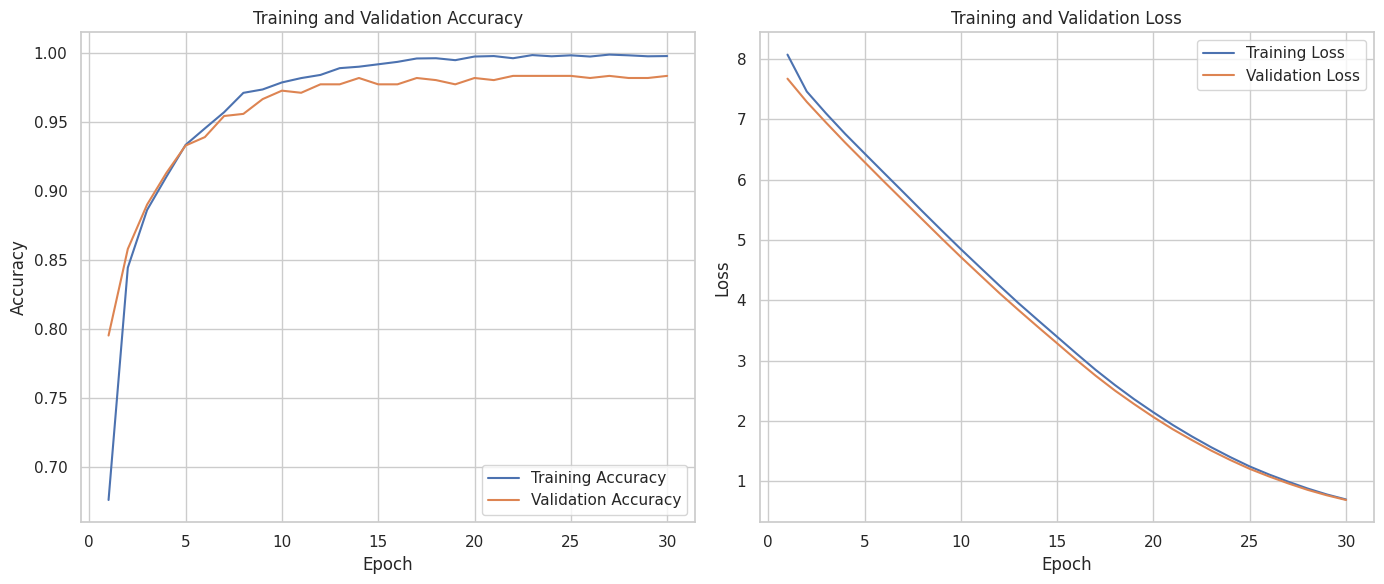

In [19]:
plot_history(history_adamax_3)

In [20]:
evaluate_model(model_adamax_3, train_generator, valid_generator,
               test_generator, 1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - accuracy: 0.9999 - loss: 0.6436
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.9796 - loss: 0.6979
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9601 - loss: 0.7408


In [21]:
y_pred_adamax_3, classes, cm_adamax_3 = predict_model(model_adamax_3, test_generator)

 3/41 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step

W0000 00:00:1721824115.334123     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721824115.334478     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721824115.334916     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721824115.335870     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721824115.336254     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721824115.336623     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721824115.336979     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721824115.337351     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step


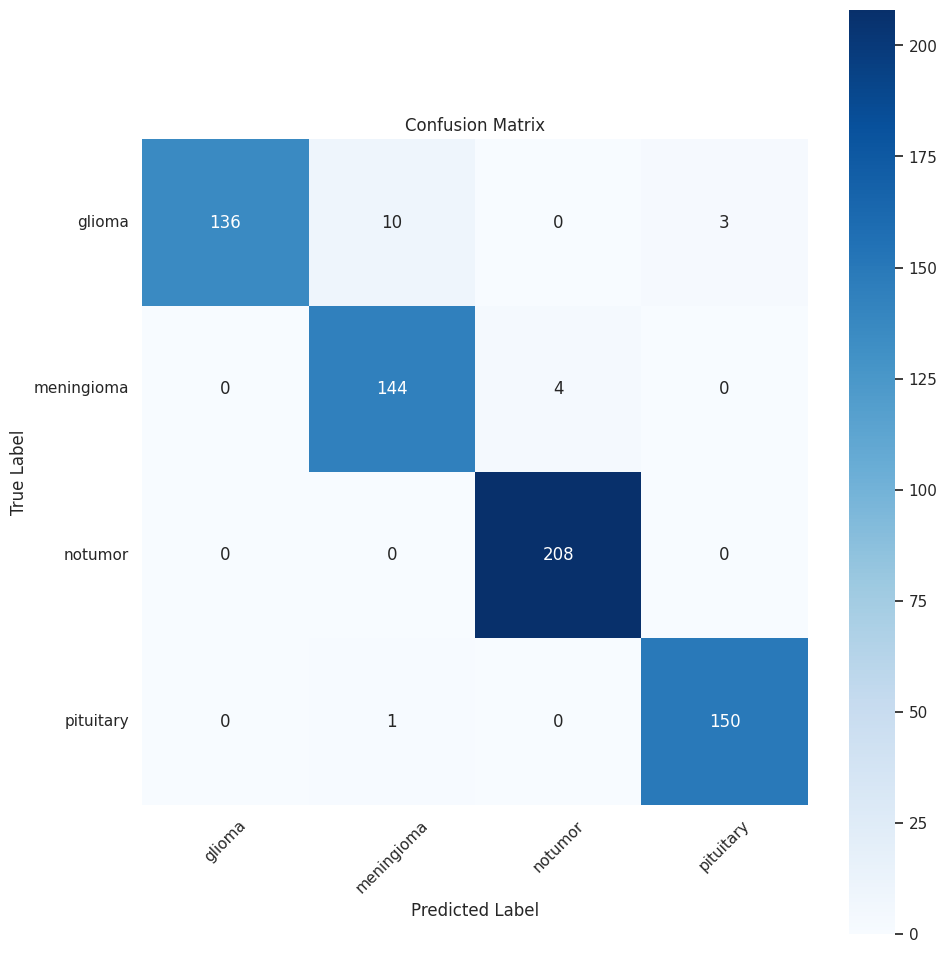

In [22]:
plot_cm(cm_adamax_3, classes)

In [23]:
report_model(test_generator, y_pred_adamax_3, classes)

              precision    recall  f1-score   support

      glioma       1.00      0.91      0.95       149
  meningioma       0.93      0.97      0.95       148
     notumor       0.98      1.00      0.99       208
   pituitary       0.98      0.99      0.99       151

    accuracy                           0.97       656
   macro avg       0.97      0.97      0.97       656
weighted avg       0.97      0.97      0.97       656



In [24]:
model_adamax_3.save('classification_brain_tumor_convnextsmall_adamax_3.h5')

### Konfigurasi model 
- learning rate = 0.0001
- dropout = 0.45

In [18]:
model_adamax_4 = model_convnextsmall(Adamax,0.0001, 0.45)

In [19]:
history_adamax_4 = history_model(model_adamax_4, train_generator, 30, 1, valid_generator, False)

Epoch 1/30
  1/357 ━━━━━━━━━━━━━━━━━━━━ 2:58:48 30s/step - accuracy: 0.1875 - loss: 9.5150

I0000 00:00:1721824680.322616     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721824680.379457     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721824680.379880     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721824680.380280     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721824680.380656     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721824680.381037     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721824680.381401     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721824680.381778     114 graph_launch.cc:671] Fallback to op-by-op mode because m

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.5070 - loss: 8.5677

W0000 00:00:1721824731.022462     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721824731.022791     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721824731.023173     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721824731.023514     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721824731.023888     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721824731.024200     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721824731.024504     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721824731.024829     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 89s 165ms/step - accuracy: 0.5073 - loss: 8.5668 - val_accuracy: 0.8031 - val_loss: 7.6719
Epoch 2/30


W0000 00:00:1721824739.195755     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721824739.196187     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721824739.196589     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721824739.202099     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721824739.202481     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721824739.202937     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 37s 103ms/step - accuracy: 0.7834 - loss: 7.7129 - val_accuracy: 0.8534 - val_loss: 7.3626
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 34s 94ms/step - accuracy: 0.8406 - loss: 7.3847 - val_accuracy: 0.8779 - val_loss: 7.1032
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 34s 95ms/step - accuracy: 0.8805 - loss: 7.0943 - val_accuracy: 0.9053 - val_loss: 6.8573
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.8941 - loss: 6.8385 - val_accuracy: 0.9313 - val_loss: 6.6159
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.9270 - loss: 6.5703 - val_accuracy: 0.9389 - val_loss: 6.3737
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9312 - loss: 6.3438 - val_accuracy: 0.9496 - val_loss: 6.1388
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.9415 - loss: 6.1011 - val_accuracy: 0.9588 - val_loss: 5.9033
Epoch 9/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.9561 - loss: 5.8593 - val_accura

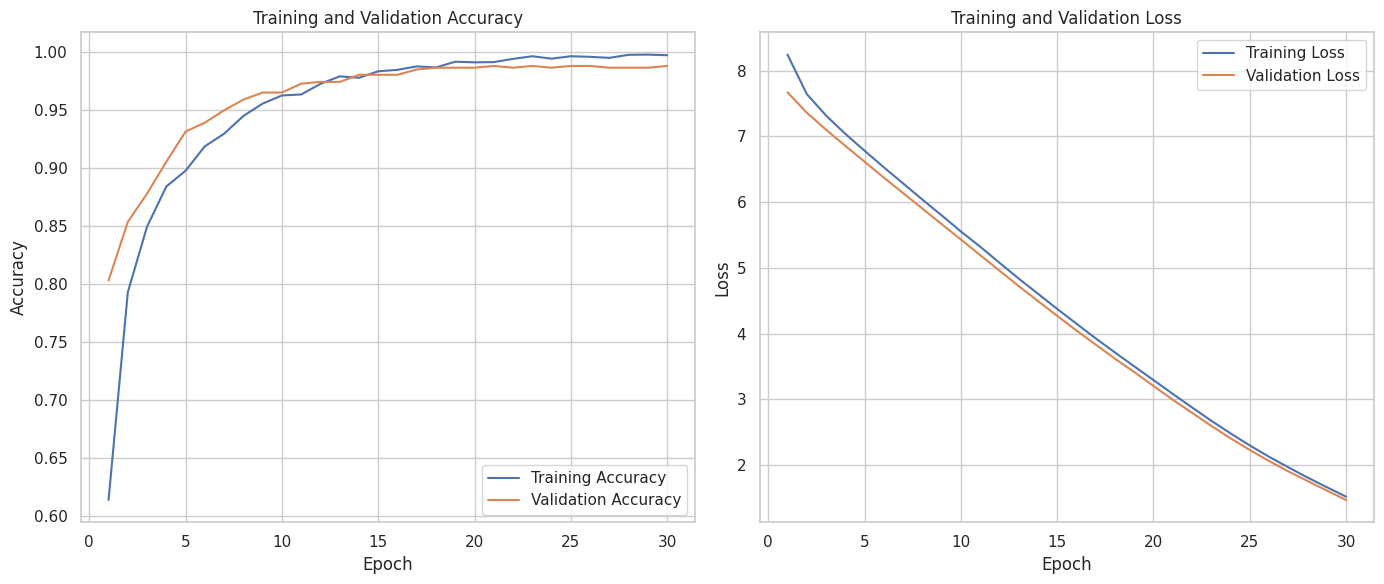

In [20]:
plot_history(history_adamax_4)

In [21]:
evaluate_model(model_adamax_4, train_generator, valid_generator,
               test_generator, 1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.9996 - loss: 1.4258
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9866 - loss: 1.4719
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9730 - loss: 1.5063


In [22]:
y_pred_adamax_4, classes, cm_adamax_4 = predict_model(model_adamax_4, test_generator)

 3/41 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step

W0000 00:00:1721826639.226176     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721826639.226634     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721826639.227058     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721826639.227424     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721826639.227836     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721826639.228192     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721826639.228562     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721826639.228930     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step


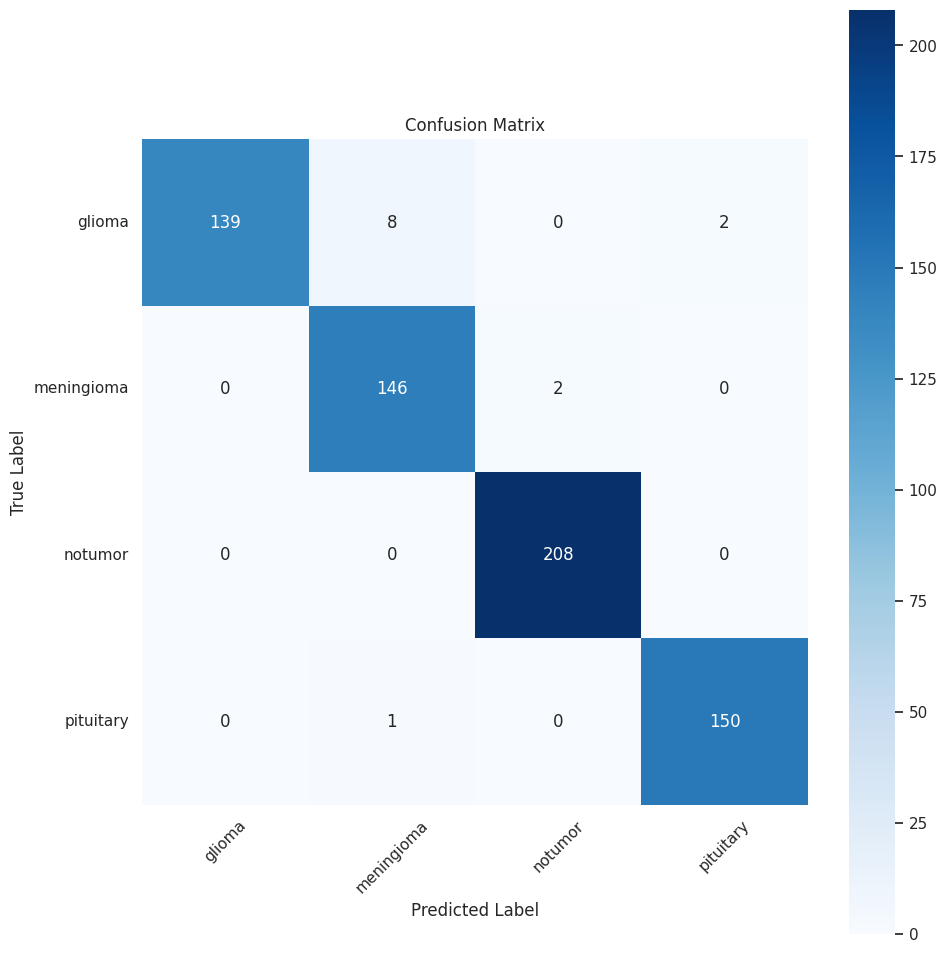

In [23]:
plot_cm(cm_adamax_4,classes)

In [24]:
report_model(test_generator, y_pred_adamax_4, classes)

              precision    recall  f1-score   support

      glioma       1.00      0.93      0.97       149
  meningioma       0.94      0.99      0.96       148
     notumor       0.99      1.00      1.00       208
   pituitary       0.99      0.99      0.99       151

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



In [25]:
model_adamax_4.save('classification_brain_tumor_convnextsmall_adamax_4.h5')

## Optimizer SGD

### Konfigurasi model
- learning rate = 0.001
- dropout = 0.25

In [17]:
model_SGD_1 = model_convnextsmall(tf.keras.optimizers.SGD,0.001, 0.25)

In [26]:
history_SGD_1 = history_model(model_SGD_1, train_generator, 30, 1, valid_generator, False)

Epoch 1/30
  1/357 ━━━━━━━━━━━━━━━━━━━━ 3:09:31 32s/step - accuracy: 0.2500 - loss: 9.1016

I0000 00:00:1721634413.193188     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721634413.251084     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721634413.251557     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721634413.252022     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721634413.253118     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721634413.253526     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721634413.253953     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721634413.254339     108 graph_launch.cc:671] Fallback to op-by-op mode because m

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.6549 - loss: 8.0863

W0000 00:00:1721634464.849657     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721634464.850152     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721634464.850494     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721634464.851515     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721634464.851912     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721634464.852276     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721634464.852677     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721634464.853037     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 92s 169ms/step - accuracy: 0.6552 - loss: 8.0852 - val_accuracy: 0.8718 - val_loss: 7.2432
Epoch 2/30


W0000 00:00:1721634473.391572     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721634473.392040     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721634473.392479     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.8914 - loss: 7.1015 - val_accuracy: 0.9023 - val_loss: 6.7205
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 32s 89ms/step - accuracy: 0.9180 - loss: 6.5962 - val_accuracy: 0.9328 - val_loss: 6.2571
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - accuracy: 0.9486 - loss: 6.1223 - val_accuracy: 0.9496 - val_loss: 5.8194
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.9600 - loss: 5.7012 - val_accuracy: 0.9679 - val_loss: 5.4129
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.9654 - loss: 5.3013 - val_accuracy: 0.9710 - val_loss: 5.0287
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - accuracy: 0.9723 - loss: 4.9170 - val_accuracy: 0.9710 - val_loss: 4.6625
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.9784 - loss: 4.5525 - val_accuracy: 0.9710 - val_loss: 4.3117
Epoch 9/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.9815 - loss: 4.2116 - val_accurac

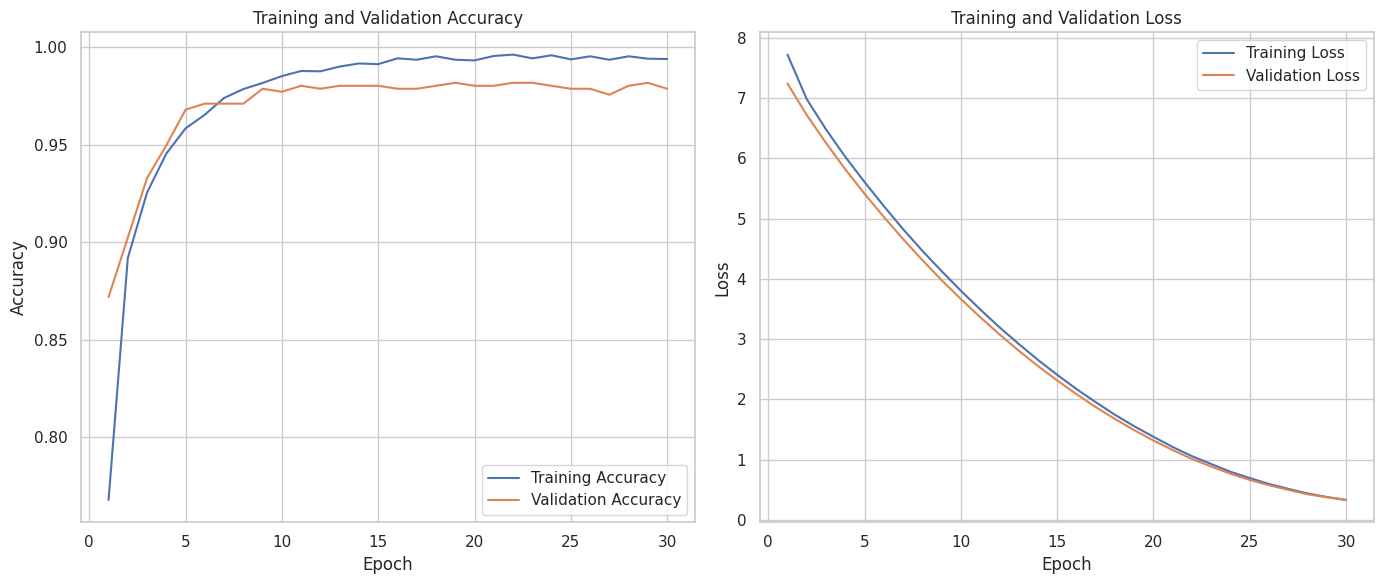

In [27]:
plot_history(history_SGD_1)

In [28]:
evaluate_model(model_SGD_1, train_generator, valid_generator,
               test_generator, 1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 33s 92ms/step - accuracy: 0.9995 - loss: 0.2789
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9824 - loss: 0.3217
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9651 - loss: 0.3686


In [30]:
y_pred_SGD_1, classes, cm_SGD_1 = predict_model(model_SGD_1, test_generator)

 3/41 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step

W0000 00:00:1721636054.283824     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721636054.284153     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721636054.284562     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721636054.285528     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721636054.285938     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721636054.286319     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721636054.286695     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721636054.287042     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step


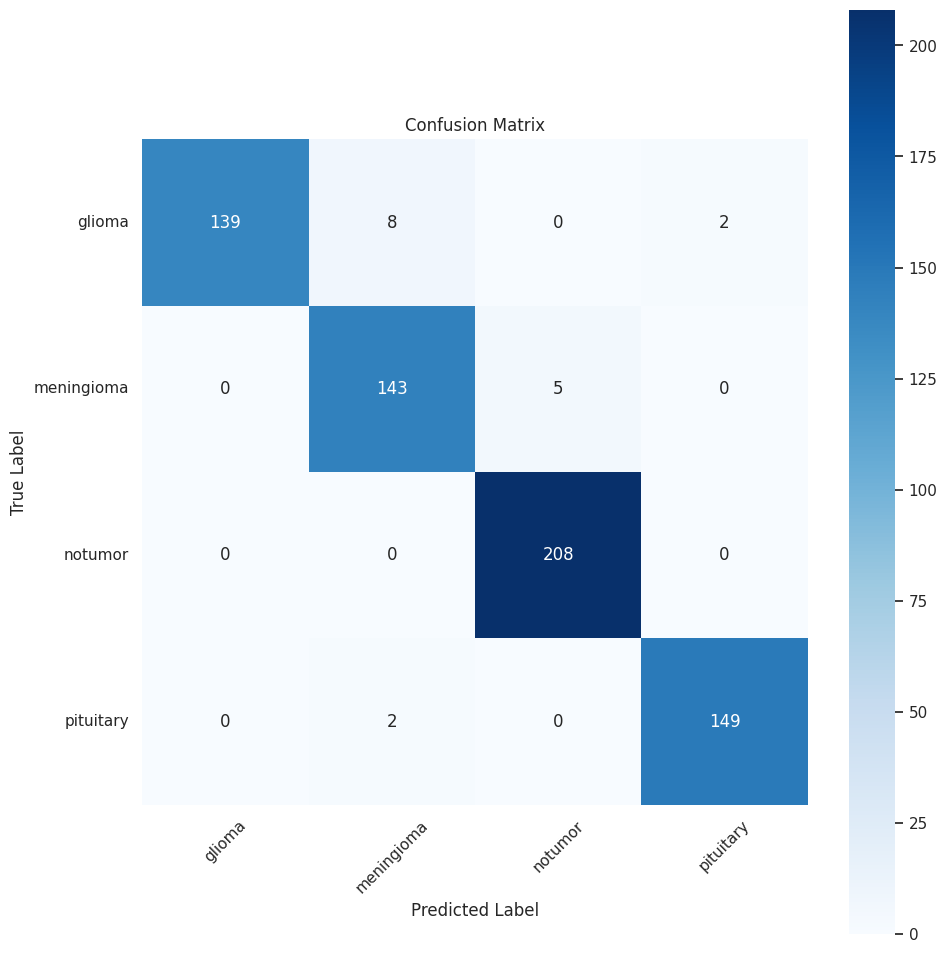

In [34]:
plot_cm(cm_SGD_1, classes)

In [35]:
report_model(test_generator, y_pred_SGD_1, classes)

              precision    recall  f1-score   support

      glioma       1.00      0.93      0.97       149
  meningioma       0.93      0.97      0.95       148
     notumor       0.98      1.00      0.99       208
   pituitary       0.99      0.99      0.99       151

    accuracy                           0.97       656
   macro avg       0.97      0.97      0.97       656
weighted avg       0.97      0.97      0.97       656



In [36]:
model_SGD_1.save('classification_brain_tumor_convnextsmall_SGD_1.h5')

### Konfigurasi model
- learning rate = 0.001
- dropout = 0.45

In [17]:
model_SGD_2 = model_convnextsmall(tf.keras.optimizers.SGD,0.001, 0.45)

In [18]:
history_SGD_2 = history_model(model_SGD_2, train_generator, 30, 1, valid_generator, False)

Epoch 1/30
  1/357 ━━━━━━━━━━━━━━━━━━━━ 2:57:16 30s/step - accuracy: 0.4375 - loss: 8.7373

I0000 00:00:1721652835.425675     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721652835.483475     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721652835.483981     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721652835.484391     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721652835.485405     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721652835.485841     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721652835.486213     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721652835.486588     111 graph_launch.cc:671] Fallback to op-by-op mode because m

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6227 - loss: 8.2131

W0000 00:00:1721652884.020971     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721652884.021318     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721652884.021741     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721652884.022696     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721652884.023021     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721652884.023329     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721652884.023624     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721652884.023945     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 87s 160ms/step - accuracy: 0.6230 - loss: 8.2120 - val_accuracy: 0.8611 - val_loss: 7.2502
Epoch 2/30


W0000 00:00:1721652892.285944     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721652892.286230     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721652892.286638     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721652892.292100     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721652892.292455     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721652892.292904     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.8595 - loss: 7.1639 - val_accuracy: 0.9191 - val_loss: 6.7063
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.8954 - loss: 6.6533 - val_accuracy: 0.9313 - val_loss: 6.2444
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.9213 - loss: 6.1691 - val_accuracy: 0.9405 - val_loss: 5.8173
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.9418 - loss: 5.7243 - val_accuracy: 0.9450 - val_loss: 5.4160
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.9488 - loss: 5.3261 - val_accuracy: 0.9618 - val_loss: 5.0223
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.9593 - loss: 4.9362 - val_accuracy: 0.9649 - val_loss: 4.6520
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.9678 - loss: 4.5718 - val_accuracy: 0.9740 - val_loss: 4.2995
Epoch 9/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.9691 - loss: 4.2229 - val_accurac

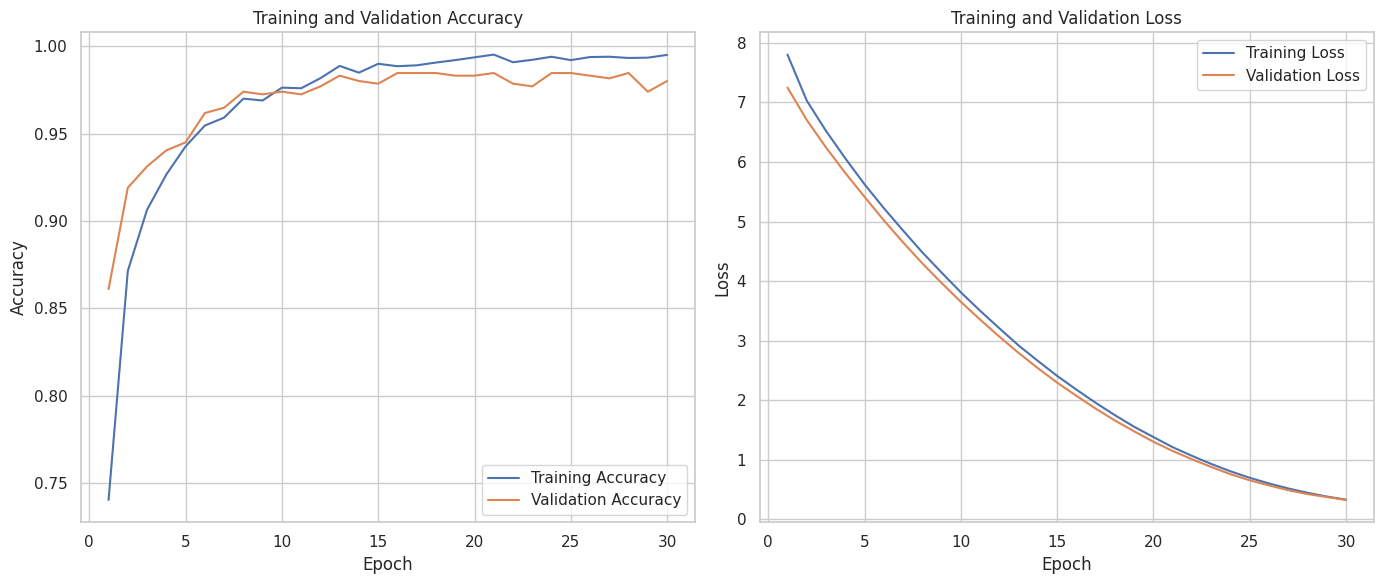

In [19]:
plot_history(history_SGD_2)

In [20]:
evaluate_model(model_SGD_2, train_generator, valid_generator,
               test_generator, 1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.9996 - loss: 0.2845
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9880 - loss: 0.3169
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9707 - loss: 0.3886


In [21]:
y_pred_SGD_2, classes, cm_SGD_2 = predict_model(model_SGD_2, test_generator)

 3/41 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step

W0000 00:00:1721654851.669755     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721654851.670165     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721654851.670648     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721654851.671628     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721654851.672010     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721654851.672348     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721654851.672716     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721654851.673060     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step


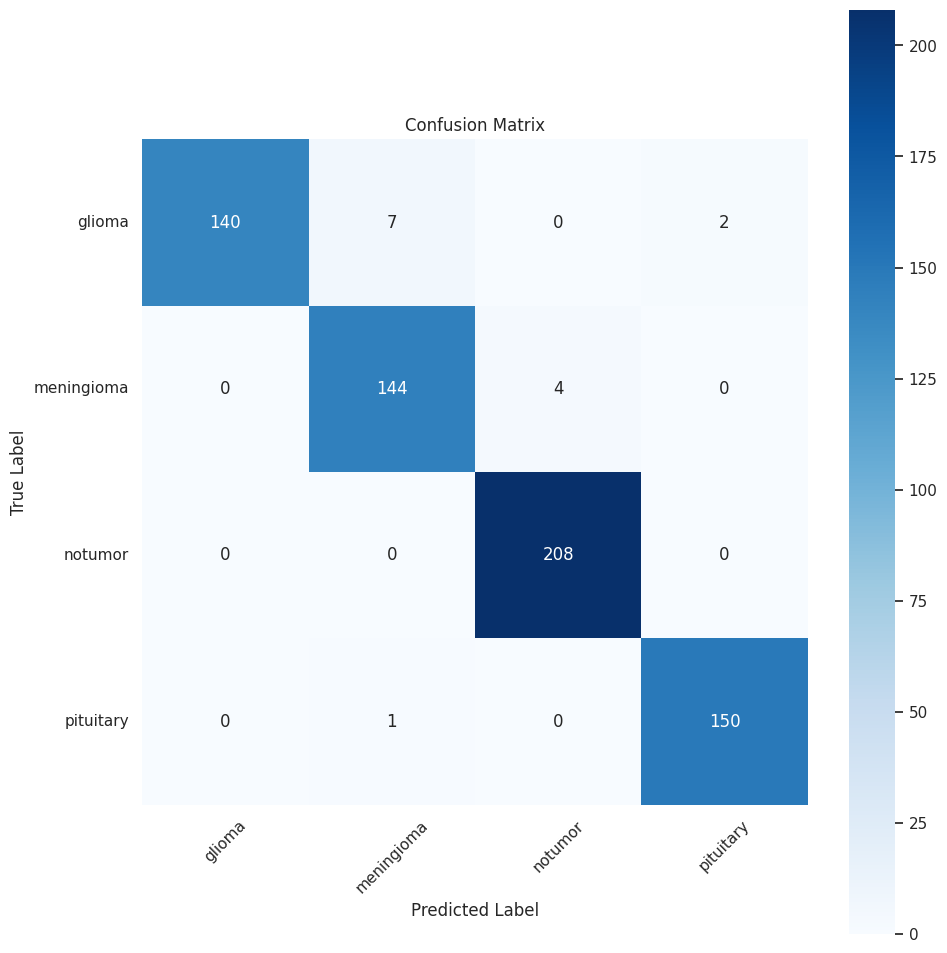

In [22]:
plot_cm(cm_SGD_2, classes)

In [23]:
report_model(test_generator, y_pred_SGD_2, classes)

              precision    recall  f1-score   support

      glioma       1.00      0.94      0.97       149
  meningioma       0.95      0.97      0.96       148
     notumor       0.98      1.00      0.99       208
   pituitary       0.99      0.99      0.99       151

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



In [24]:
model_SGD_2.save('classification_brain_tumor_convnextsmall_SGD_2.h5')

### Konfigurasi model
- learning rate = 0.0001
- learning rate = 0.25

In [17]:
model_SGD_3 = model_convnextsmall(tf.keras.optimizers.SGD,0.0001, 0.25)

In [18]:
history_SGD_3 = history_model(model_SGD_3, train_generator, 30, 1, valid_generator, False)

Epoch 1/30
  1/357 ━━━━━━━━━━━━━━━━━━━━ 2:47:44 28s/step - accuracy: 0.1875 - loss: 9.7399

I0000 00:00:1721656917.367050     105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721656917.431496     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721656917.431913     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721656917.432323     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721656917.432687     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721656917.433142     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721656917.433558     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721656917.433909     105 graph_launch.cc:671] Fallback to op-by-op mode because m

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.3711 - loss: 8.8459

W0000 00:00:1721656965.601301     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721656965.601681     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721656965.602053     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721656965.602416     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721656965.602770     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721656965.603133     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721656965.603479     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721656965.603817     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 84s 157ms/step - accuracy: 0.3714 - loss: 8.8450 - val_accuracy: 0.6809 - val_loss: 8.0782
Epoch 2/30


W0000 00:00:1721656973.441259     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721656973.441702     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721656973.442125     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721656973.447914     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721656973.448319     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721656973.448756     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.6819 - loss: 8.0870 - val_accuracy: 0.7740 - val_loss: 7.8583
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.7690 - loss: 7.8630 - val_accuracy: 0.8137 - val_loss: 7.7334
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.7952 - loss: 7.7534 - val_accuracy: 0.8198 - val_loss: 7.6378
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.8174 - loss: 7.6452 - val_accuracy: 0.8244 - val_loss: 7.5614
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.8346 - loss: 7.5613 - val_accuracy: 0.8305 - val_loss: 7.4888
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.8346 - loss: 7.4968 - val_accuracy: 0.8412 - val_loss: 7.4198
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.8564 - loss: 7.4164 - val_accuracy: 0.8443 - val_loss: 7.3548
Epoch 9/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.8573 - loss: 7.3563 - val_accurac

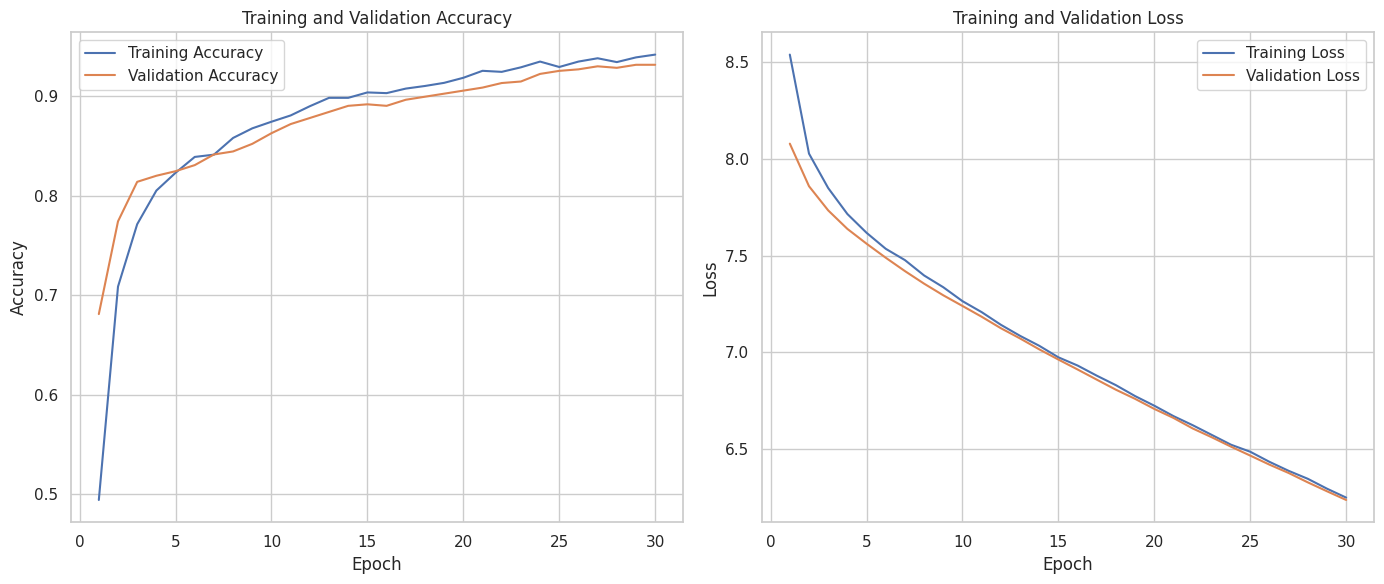

In [19]:
plot_history(history_SGD_3)

In [20]:
evaluate_model(model_SGD_3, train_generator, valid_generator,
               test_generator, 1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.9688 - loss: 6.1615
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9409 - loss: 6.2242
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.9177 - loss: 6.2761


In [21]:
y_pred_SGD_3, classes, cm_SGD_3 = predict_model(model_SGD_3, test_generator)

 4/41 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step

W0000 00:00:1721657984.204973     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721657984.205284     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721657984.205824     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721657984.206245     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721657984.206608     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721657984.206969     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721657984.207374     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721657984.207723     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step


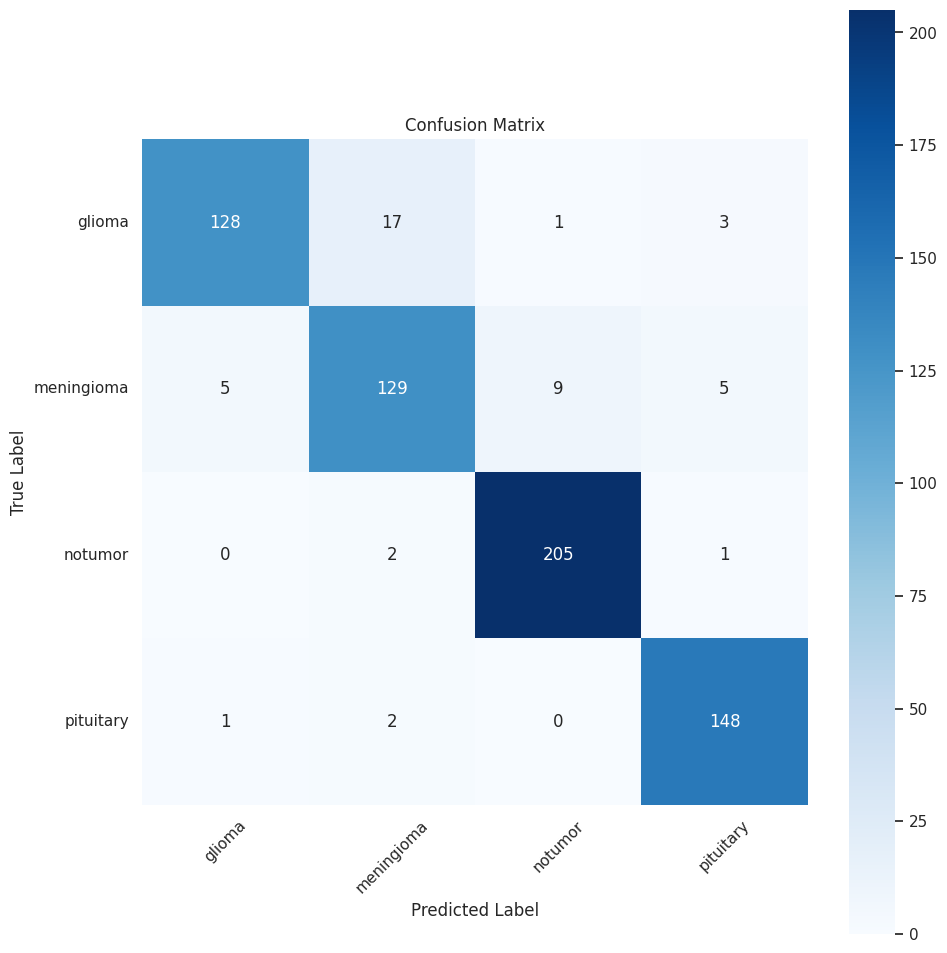

In [22]:
plot_cm(cm_SGD_3, classes)

In [23]:
report_model(test_generator, y_pred_SGD_3, classes)

              precision    recall  f1-score   support

      glioma       0.96      0.86      0.90       149
  meningioma       0.86      0.87      0.87       148
     notumor       0.95      0.99      0.97       208
   pituitary       0.94      0.98      0.96       151

    accuracy                           0.93       656
   macro avg       0.93      0.92      0.93       656
weighted avg       0.93      0.93      0.93       656



In [24]:
model_SGD_3.save('classification_brain_tumor_convnextsmall_SGD_3.h5')

### Konfigurasi model
- learning rate = 0.0001
- dropout = 0.45

In [17]:
model_SGD_4 = model_convnextsmall(tf.keras.optimizers.SGD,0.0001, 0.45)

In [18]:
history_SGD_4 = history_model(model_SGD_4, train_generator, 30, 1, valid_generator, False)

Epoch 1/30
  1/357 ━━━━━━━━━━━━━━━━━━━━ 2:52:16 29s/step - accuracy: 0.1875 - loss: 9.3266

I0000 00:00:1721661184.616821     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721661184.671885     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721661184.672289     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721661184.672649     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721661184.672985     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721661184.673342     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721661184.673677     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721661184.674048     113 graph_launch.cc:671] Fallback to op-by-op mode because m

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.3726 - loss: 8.9029

W0000 00:00:1721661248.982591     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721661248.982991     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721661248.983439     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721661248.983877     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721661248.984272     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721661248.984684     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721661248.985121     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721661248.985490     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 103s 208ms/step - accuracy: 0.3729 - loss: 8.9020 - val_accuracy: 0.7069 - val_loss: 8.0485
Epoch 2/30


W0000 00:00:1721661258.641042     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721661258.641438     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721661258.641810     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721661258.647926     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721661258.648314     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721661258.648718     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.6612 - loss: 8.1571 - val_accuracy: 0.7695 - val_loss: 7.8473
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.7295 - loss: 7.9662 - val_accuracy: 0.7985 - val_loss: 7.7220
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.7618 - loss: 7.8034 - val_accuracy: 0.8137 - val_loss: 7.6246
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.7814 - loss: 7.7240 - val_accuracy: 0.8290 - val_loss: 7.5498
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.8057 - loss: 7.6232 - val_accuracy: 0.8366 - val_loss: 7.4769
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.8281 - loss: 7.5328 - val_accuracy: 0.8504 - val_loss: 7.4070
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.8392 - loss: 7.4522 - val_accuracy: 0.8595 - val_loss: 7.3441
Epoch 9/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.8498 - loss: 7.3809 - val_accurac

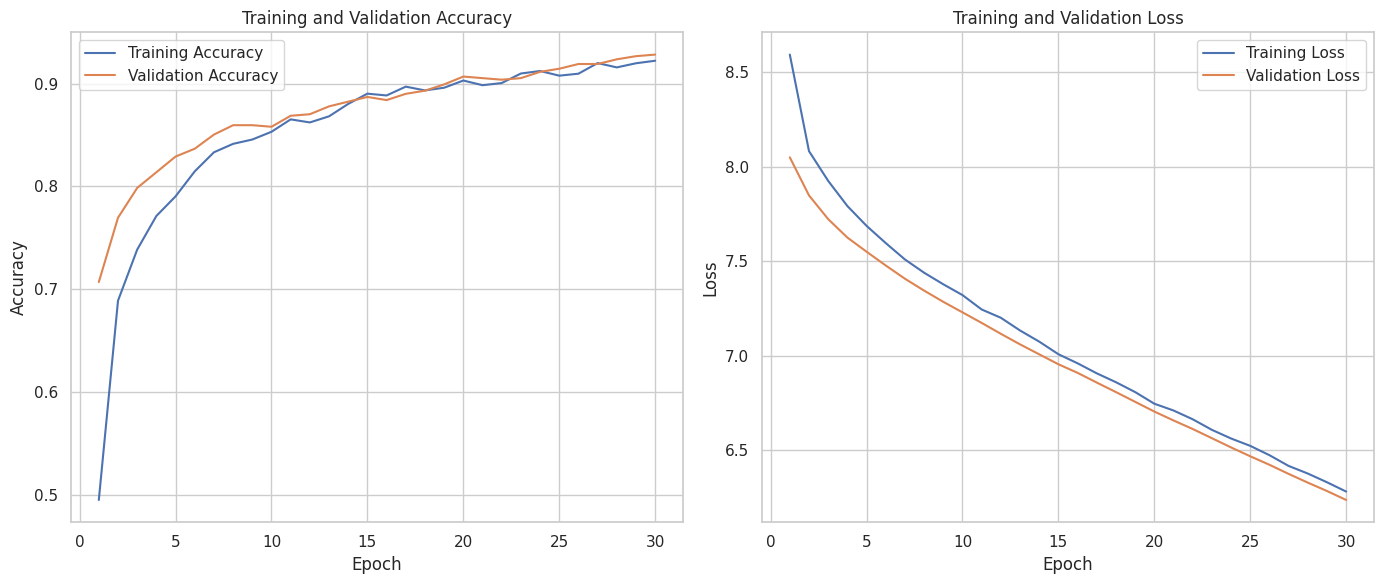

In [19]:
plot_history(history_SGD_4)

In [20]:
evaluate_model(model_SGD_4, train_generator, valid_generator,
               test_generator, 1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.9677 - loss: 6.1593
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9345 - loss: 6.2229
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9085 - loss: 6.2741


In [21]:
y_pred_SGD_4, classes, cm_SGD_4 = predict_model(model_SGD_4, test_generator)

 4/41 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step

W0000 00:00:1721662174.876658     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721662174.877039     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721662174.877449     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721662174.877780     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721662174.878151     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721662174.878513     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721662174.878864     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721662174.879193     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step


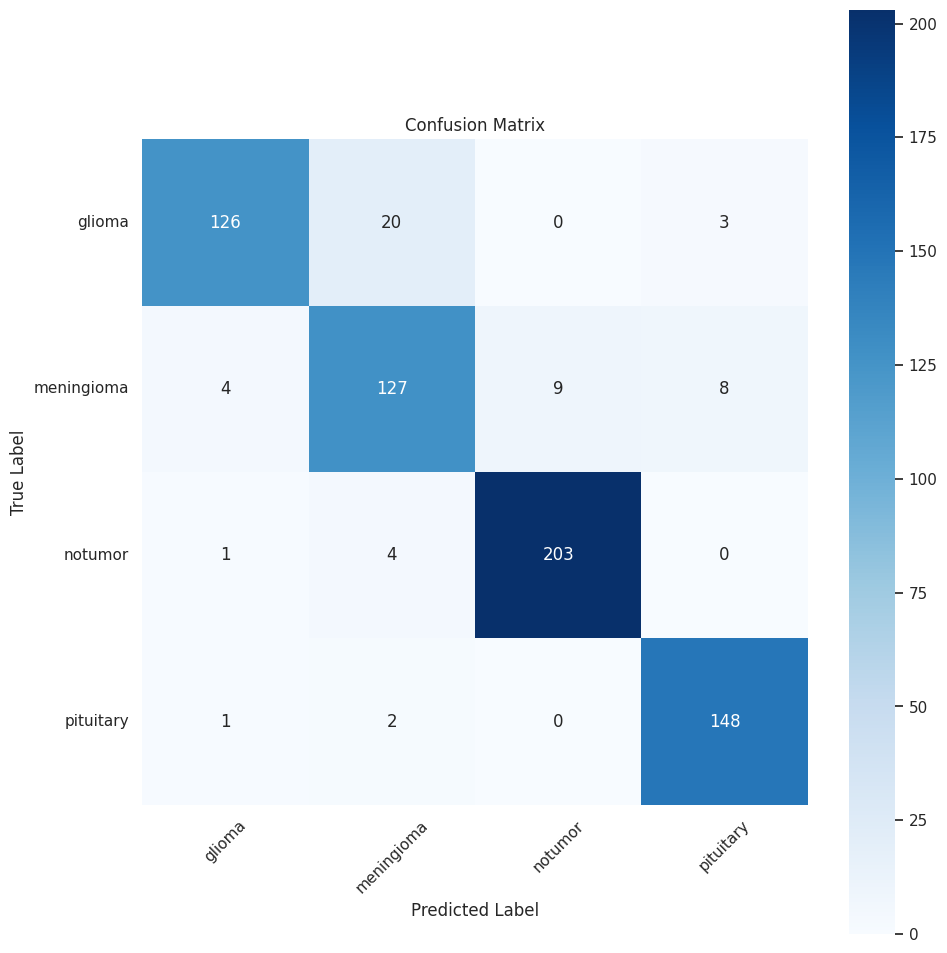

In [22]:
plot_cm(cm_SGD_4,classes)

In [23]:
report_model(test_generator, y_pred_SGD_4, classes)

              precision    recall  f1-score   support

      glioma       0.95      0.85      0.90       149
  meningioma       0.83      0.86      0.84       148
     notumor       0.96      0.98      0.97       208
   pituitary       0.93      0.98      0.95       151

    accuracy                           0.92       656
   macro avg       0.92      0.91      0.92       656
weighted avg       0.92      0.92      0.92       656



In [24]:
model_SGD_4.save('classification_brain_tumor_convnextsmall_SGD_4.h5')